# Data preparation

## Library import

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import EarlyStopping

from keras_tuner import HyperModel
from keras_tuner import Objective
from keras_tuner.tuners import BayesianOptimization

from keras.regularizers import l1, l2, l1_l2

from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager

import time

import shutil

## Use Colissimo font for Matplotlib

In [2]:
font_path = '/Users/anthony/spyder-py3/Font/Monserrat/Montserrat-Regular.otf'

font_manager.fontManager.addfont(font_path)

plt.rcParams['font.family'] = 'Montserrat'

## Read dataset

In [3]:
# Read main data
data = pd.read_excel('data/traffic_tg1.xlsx', index_col='date')
data.index = pd.to_datetime(data.index)

# Read holiday day data
holidays_data = pd.read_excel('data/public_holiday.xlsx')
holidays_data['date'] = pd.to_datetime(holidays_data['date'])

## Create dummies

In [4]:
#Create dummies

# Create a dummy for holiday
data['is_holiday'] = data.index.isin(holidays_data['date']).astype(int)

# Function creation

## Custom MAPE/MAE function loss

In [5]:
def custom_mape(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mask = tf.math.greater(y_true, 0)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    diff = tf.abs((y_true_masked - y_pred_masked) / y_true_masked)
    return 100. * tf.reduce_mean(diff)

def custom_mae(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mask = tf.math.greater(y_true, 0)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    diff = tf.abs(y_true_masked - y_pred_masked)
    return 100. * tf.reduce_mean(diff)

## CNN model

In [6]:
def create_cnn_model(filters, kernel_size, activation, n_steps_in, n_features, optimizer, loss, 
                     reg_type=None, l1_value=0.0, l2_value=0.0):
    if reg_type == 'l1':
        kernel_regularizer = l1(l1_value)
    elif reg_type == 'l2':
        kernel_regularizer = l2(l2_value)
    elif reg_type == 'l1_l2':
        kernel_regularizer = l1_l2(l1=l1_value, l2=l2_value)
    else:
        kernel_regularizer = None
    
    model = Sequential()
    model.add(Conv1D(filters=filters, 
                     kernel_size=kernel_size, 
                     activation=activation, 
                     kernel_regularizer=kernel_regularizer, 
                     input_shape=(n_steps_in, n_features)))
    model.add(Conv1D(filters=filters, 
                     kernel_size=7, 
                     activation=activation, 
                     kernel_regularizer=kernel_regularizer))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=[custom_mape, custom_mae])
    return model

## LSTM model

In [7]:
# Define a function to create a sequential CNN model
def create_lstm_model(units, n_steps_in, n_features, optimizer, loss, l1_reg=0, l2_reg=0):
    model = Sequential()
    model.add(LSTM(units=units, 
                     input_shape=(n_steps_in, n_features),
                  kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),  # Régularisation pour les poids d'entrée
                   recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)  # Régularisation pour les poids récurrents
                  ))
    #model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=[custom_mape, custom_mae])
    return model

## Scale data

In [8]:
# Scale data between 0 and 1
def scale_data(data):
    scalers = {}
    data_normalized = data.copy()
    for column in data.columns:
        scaler = MinMaxScaler()
        data_normalized[column] = scaler.fit_transform(data[[column]])
        scalers[column] = scaler
    return data_normalized, scalers

## Data transformation

In [9]:
# Define a function to transfrom data for CNN model
def transform_data_cnn(data_normalized, n_steps_in, start_date, end_date):    
    X, y, dates = [], [], []
    # Filter data based on the start and end dates
    data_filtered = data_normalized[start_date:end_date]
    # Create sequence data of n_steps_in days and n_steps_out days
    for i in range(n_steps_in, len(data_filtered)):
        X.append(data_filtered.iloc[i-n_steps_in:i])
        y.append(data_filtered.iloc[i]['tg1_traffic']) #0 because we just want to predict traffic
        dates.append(data_filtered.index[i])
    X, y, dates = np.array(X), np.array(y), np.array(dates)
    return X, y, dates




## Transfer learning

In [10]:
def transfer_learning(X_train, y_train, n_steps_in, model_params, test_dates, y_test, model):
    # Initialize empty list to save forecast
    daily_predictions = []
    eight_day_predictions = [0] * len(test_dates)
    
    for i, date in enumerate(test_dates):
        
        # Get traffic of last day to update X_train
        if i == 0:
            new_traffic_point = y_train[-1] # for first forecast, need to take last traffic in train data
        else:
            new_traffic_point = y_test[i-1]
            
        # Create dummies for new datapoint
        current_date = test_dates[i] # forecast's day
        is_holiday = 1 if current_date in holidays_data['date'].values else 0

        # Create new data point with traffic and dummies
        new_data_point = [new_traffic_point, is_holiday]
        new_data_point_array=np.array([new_data_point])

        # Update X_train and y_train
        new_X = np.append(X_train[-1][1:], new_data_point_array, axis=0)
        X_train = np.append(X_train, [new_X], axis=0)
        y_train = np.append(y_train, [y_test[i]])
    
        # Quick update of model for learning transfer
        model.fit(X_train, y_train, epochs=1, verbose=0)

        # Make 1-day forecast
        
        prediction = model.predict(X_train[-1].reshape(1, n_steps_in, 2), verbose=0) 
        daily_predictions.append(prediction[0])
        
        # if current date is a Thursday, need to make a 8-day forecast
        if date.weekday() == 3:
            eight_days_data = X_train[-1]
            local_predictions = []
            for k in range(6):
                if i + k < len(test_dates):  # Check that the index does not go beyond the length of test_dates
                    current_date = test_dates[i+k]
                    is_holiday = 1 if current_date in holidays_data['date'].values else 0

                    # Créez un nouveau point de données avec le trafic et les dummies
                    new_prediction_point = [prediction[0][0], is_holiday]
                    new_prediction_point_array = np.array([new_prediction_point])
                    eight_days_data = np.append(eight_days_data[1:], new_prediction_point_array, axis=0)
                    prediction = model.predict(eight_days_data.reshape(1, n_steps_in, 2), verbose=0)
                    local_predictions.append(prediction[0])
            for j in range(min(5, len(local_predictions)-1)):
                index_to_assign = i+2+j
                if index_to_assign < len(eight_day_predictions):
                    eight_day_predictions[index_to_assign] = local_predictions[1+j][0]




    return daily_predictions, eight_day_predictions



## Rescale data

In [11]:
def rescale_predictions(predictions, scaler):
    predictions_array = np.array(predictions)
    return scaler.inverse_transform(predictions_array.reshape(-1, 1))

## Plot test results

In [12]:
def plot_test_results_from_df(df, title):
    plt.figure(figsize=(15, 7))
    plt.title(title)
    
    # Extraire les données du DataFrame
    test_dates = df.index
    y_test = df['Trafic TG1'].values
    y_test_forecast = df['Prévision globale'].values
    daily_forecast = df['Prévision journalière'].values
    weekly_forecast = df['Prévision hebdomadaire'].values

    # Remplir la zone d'erreur acceptable (+-5%)
    upper_bound = [val * 1.05 for val in y_test]
    lower_bound = [val * 0.95 for val in y_test]
    plt.fill_between(test_dates, upper_bound, lower_bound, color='blue', alpha=0.2)
    
    # Affichage de la prévision lancée d'un coup
    plt.plot(test_dates, y_test_forecast, label='Prévision globale', color='green', marker='o')
    
    # Affichage des prévisions quotidiennes
    plt.plot(test_dates, daily_forecast, label='Prévision journalière', color='red', marker='x')
    
    # Affichage des prévisions hebdomadaires
    plt.plot(test_dates, weekly_forecast, label='Prévision hebdomadaire', color='purple', marker='s')
    
    # Affichage du trafic réel    
    plt.plot(test_dates, y_test, label='Trafic réel', color='blue', linewidth=2)
    

    plt.xlabel('Date')
    plt.ylabel('Trafic')
    plt.legend()
    plt.grid(False)
    plt.show()

## Plot train results

In [13]:
def plot_train_results_from_df(df, title):
    plt.figure(figsize=(15, 7))
    plt.title(title)
    
    # Extraire les données du DataFrame
    train_dates = df.index
    y_train = df['Trafic TG1'].values
    y_train_forecast = df['Prévision globale'].values

    # Remplir la zone d'erreur acceptable (+-5%)
    upper_bound = [val * 1.05 for val in y_train]
    lower_bound = [val * 0.95 for val in y_train]
    plt.fill_between(train_dates, upper_bound, lower_bound, color='blue', alpha=0.2)
    

    
    
    # Affichage du trafic réel    
    plt.plot(train_dates, y_train, label='Trafic réel', color='blue')
    # Affichage de la prévision lancée d'un coup
    plt.plot(train_dates, y_train_forecast, label='Prévision globale', color='green', linewidth = 2)
    

    plt.xlabel('Date')
    plt.ylabel('Trafic')
    plt.legend()
    plt.grid(False)
    plt.show()

## Calculate MAPE

In [14]:
def calculate_mean_max_mape(actual, forecast):
    # Éviter la division par zéro et les erreurs NaN
    mask = actual != 0
    mape_values = np.abs((actual[mask] - forecast[mask]) / actual[mask]) * 100
    return np.mean(mape_values), np.max(mape_values)

def compute_mape_for_columns(df, actual_col, forecast_cols):
    mape_stats = {}
    for col in forecast_cols:
        valid_forecast_mask = ~df[col].isna()
        avg_mape, max_mape = calculate_mean_max_mape(df[actual_col][valid_forecast_mask], df[col][valid_forecast_mask])
        mape_stats[col] = {"avg_mape": avg_mape, "max_mape": max_mape}
    return mape_stats

## Create tuner LSTM function

In [15]:
def build_lstm_model(hp):
    model = Sequential()
    
    # Définir un espace de recherche pour le nombre d'unités LSTM
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=512, step=32),
        input_shape=(n_steps_in, 2), # Remplacer par la forme de vos données d'entrée
        kernel_regularizer=l1_l2(
            l1=hp.Float('l1_regularization', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-4),
            l2=hp.Float('l2_regularization', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-4)
        )
    ))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer='adam',
        loss=custom_mape,
        metrics=[custom_mape, custom_mae]
    )
    
    return model
# Define a function to create a sequential CNN model
def create_cnn_model(filters, kernel_size, activation, n_steps_in, n_features, optimizer, loss):
    model = Sequential()
    model.add(Conv1D(filters=filters, 
                     kernel_size=kernel_size, 
                     activation=activation, 
                     input_shape=(n_steps_in, n_features)))
    model.add(Conv1D(filters=filters, 
                     kernel_size=7, 
                     activation=activation))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=[custom_mape, custom_mae])
    return model

# Data preparation

Take out saturday and sunday of data, normalized the data before creating training and test dataset.
<br>
n_steps_in is the number of week $\times$ number of day in a week (here 5)

In [16]:
# Exclusion des jours de la semaine (samedi et dimanche)
data = data[(data.index.dayofweek != 5) & (data.index.dayofweek != 6)]

data_normalized, scaler = scale_data(data)

n_steps_in =260

X_train, y_train, train_dates = transform_data_cnn(data_normalized, 
                                                   n_steps_in,  
                                                   '2017-01-01', 
                                                   '2021-12-31')

X_test, y_test, test_dates = transform_data_cnn(data_normalized, 
                                                n_steps_in, 
                                                '2022-01-01', 
                                                '2023-01-15')

# Tuning

In [ ]:
directory_to_delete = "keras_tuner_dir"
shutil.rmtree(directory_to_delete)

early_stop = EarlyStopping(monitor='val_custom_mape', patience=10, restore_best_weights=True)

# Définissez la recherche d'hyperparamètres
tuner = BayesianOptimization(
    build_lstm_model,
    objective=Objective(name='val_custom_mape', direction='min'),  # Nous optimisons sur la MAPE
    max_trials=100,  # nombre d'essais pour le tuning
    directory='keras_tuner_dir',  # dossier pour stocker les logs
    project_name='traffic_optimization'
)

# Recherche des meilleurs hyperparamètres
tuner.search(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=50, 
    callbacks=[early_stop]
)


best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Model creation

## Model parameters

In [ ]:
# CNN model parameters
model_params_CNN = {
    "filters": 64,
    "kernel_size": 7,
    "activation": "relu",
    "n_steps_in": n_steps_in,
    "n_features": 2,
    "optimizer": 'adam',
    "loss": custom_mape
}
# LSTM model parameters
model_params_LSTM = {
    "units": 64,
    "n_steps_in": n_steps_in,
    "n_features": 2,
    "optimizer": 'adam',
    "loss": custom_mape
}

## Model creation

In [ ]:
#cnn_model = create_cnn_model(**model_params_CNN)
lstm_model = create_lstm_model(**model_params_LSTM)
#history = cnn_model.fit(X_train, y_train, epochs=40)
history = lstm_model.fit(X_train, y_train, epochs=200)
# Historique des pertes
train_loss = history.history['loss']

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Global forecast

In [ ]:
y_train_forecast = cnn_model.predict(X_train)
y_test_forecast = cnn_model.predict(X_test)

## Daily and Weekly Forecast

In [ ]:
start_time = time.time()
daily_forecast, weekly_forecast = transfer_learning(X_train,y_train,n_steps_in,model_params,test_dates,y_test,cnn_model)
print("--- Transfert d'apprentissage: %s seconds ---" % (time.time() - start_time))

# Data analysis

## Rescale data

In [ ]:
y_train_forecast_rescaled = rescale_predictions(y_train_forecast, scaler['tg1_traffic'])
y_train_rescaled = rescale_predictions(y_train, scaler['tg1_traffic'])


y_test_forecast_rescaled = rescale_predictions(y_test_forecast, scaler['tg1_traffic'])
y_test_rescaled = rescale_predictions(y_test, scaler['tg1_traffic'])



daily_forecast_rescaled = rescale_predictions(daily_forecast, scaler['tg1_traffic'])
weekly_forecast_rescaled = rescale_predictions(weekly_forecast, scaler['tg1_traffic'])

## Concatenate forecast in dataframe

In [ ]:
data_train_forecast = pd.DataFrame({
    'Trafic TG1' : y_train_rescaled.flatten().tolist() ,
    'Prévision globale' : y_train_forecast_rescaled.flatten().tolist()
                            }, index = train_dates.tolist())

data_test_forecast = pd.DataFrame({
    'Trafic TG1' : y_test_rescaled.flatten().tolist() ,
    'Prévision globale' : y_test_forecast_rescaled.flatten().tolist(),
    'Prévision hebdomadaire' : weekly_forecast_rescaled.flatten().tolist(),
    'Prévision journalière' : daily_forecast_rescaled.flatten().tolist()  
                            }, index = test_dates.tolist())

## Plot results

In [ ]:
plot_test_results_from_df(data_test_forecast, 'Transfert d’apprentissage')

In [ ]:
plot_train_results_from_df(data_train_forecast, "Résultats d'entraînement")

## Metrics

In [ ]:
# Utilisation de la fonction:
forecast_columns = ['Prévision globale', 'Prévision journalière', 'Prévision hebdomadaire']
mapes = compute_mape_for_columns(data_test_forecast, 'Trafic TG1', forecast_columns)

for col, mape_stats in mapes.items():
    avg_mape = mape_stats['avg_mape']
    max_mape = mape_stats['max_mape']
    print(f"MAPE moyen {col} : {avg_mape:.2f}%")
    print(f"MAPE max {col} : {max_mape:.2f}%")
    print("-" * 30)  # Juste pour séparer visuellement les différentes prévisions


In [ ]:
# Utilisation de la fonction:
forecast_columns = ['Prévision globale']
mapes = compute_mape_for_columns(data_train_forecast, 'Trafic TG1', forecast_columns)

for col, mape_stats in mapes.items():
    avg_mape = mape_stats['avg_mape']
    max_mape = mape_stats['max_mape']
    print(f"MAPE moyen {col} : {avg_mape:.2f}%")
    print(f"MAPE max {col} : {max_mape:.2f}%")

# Tuning

## Run CNN

In [42]:
def run_cnn(model_params):
    cnn_model = create_cnn_model(**model_params)
    history = cnn_model.fit(X_train, y_train, epochs=60)
    # Historique des pertes
    train_loss = history.history['loss']

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    y_train_forecast = cnn_model.predict(X_train)
    y_test_forecast = cnn_model.predict(X_test)

    daily_forecast, weekly_forecast = transfer_learning(X_train,y_train,n_steps_in,model_params,test_dates,y_test,cnn_model)
    
    y_train_forecast_rescaled = rescale_predictions(y_train_forecast, scaler['tg1_traffic'])
    y_train_rescaled = rescale_predictions(y_train, scaler['tg1_traffic'])


    y_test_forecast_rescaled = rescale_predictions(y_test_forecast, scaler['tg1_traffic'])
    y_test_rescaled = rescale_predictions(y_test, scaler['tg1_traffic'])



    daily_forecast_rescaled = rescale_predictions(daily_forecast, scaler['tg1_traffic'])
    weekly_forecast_rescaled = rescale_predictions(weekly_forecast, scaler['tg1_traffic'])
    
    data_train_forecast = pd.DataFrame({
    'Trafic TG1' : y_train_rescaled.flatten().tolist() ,
    'Prévision globale' : y_train_forecast_rescaled.flatten().tolist()
                            }, index = train_dates.tolist())

    data_test_forecast = pd.DataFrame({
    'Trafic TG1' : y_test_rescaled.flatten().tolist() ,
    'Prévision globale' : y_test_forecast_rescaled.flatten().tolist(),
    'Prévision hebdomadaire' : weekly_forecast_rescaled.flatten().tolist(),
    'Prévision journalière' : daily_forecast_rescaled.flatten().tolist()  
                            }, index = test_dates.tolist())
    
    plot_test_results_from_df(data_test_forecast, 'Transfert d’apprentissage')
    plot_train_results_from_df(data_train_forecast, "Résultats d'entraînement")
    
    mapes_train = {}
    mapes_test = {}
    
    # Calcul des MAPE pour les données d'entraînement
    forecast_columns_train = ['Prévision globale']
    mapes_train = compute_mape_for_columns(data_train_forecast, 'Trafic TG1', forecast_columns_train)
    
    for col, values in mapes_train.items():
        avg_mape = values['avg_mape']
        max_mape = values['max_mape']
        print(f"Train MAPE {col} - Average: {avg_mape:.2f}% | Max: {max_mape:.2f}%")
    
    # Calcul des MAPE pour les données de test
    forecast_columns_test = ['Prévision globale', 'Prévision journalière', 'Prévision hebdomadaire']
    mapes_test = compute_mape_for_columns(data_test_forecast, 'Trafic TG1', forecast_columns_test)
    
    for col, values in mapes_test.items():
        avg_mape = values['avg_mape']
        max_mape = values['max_mape']
        print(f"Test MAPE {col} - Average: {avg_mape:.2f}% | Max: {max_mape:.2f}%")

    return mapes_train, mapes_test

## Run LSTM

In [ ]:
def run_lstm(model_params):
    lstm_model = create_lstm_model(**model_params)
    history = lstm_model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val))
    # Historique des pertes
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    y_train_forecast = lstm_model.predict(X_train)
    y_val_forecast = lstm_model.predict(X_test)

    daily_forecast, weekly_forecast = transfer_learning(X_train,y_train,n_steps_in,model_params,val_dates,y_val,lstm_model)
    
    y_train_forecast_rescaled = rescale_predictions(y_train_forecast, scaler['tg1_traffic'])
    y_train_rescaled = rescale_predictions(y_train, scaler['tg1_traffic'])


    y_val_forecast_rescaled = rescale_predictions(y_val_forecast, scaler['tg1_traffic'])
    y_val_rescaled = rescale_predictions(y_val, scaler['tg1_traffic'])



    daily_forecast_rescaled = rescale_predictions(daily_forecast, scaler['tg1_traffic'])
    weekly_forecast_rescaled = rescale_predictions(weekly_forecast, scaler['tg1_traffic'])
    
    data_train_forecast = pd.DataFrame({
    'Trafic TG1' : y_train_rescaled.flatten().tolist() ,
    'Prévision globale' : y_train_forecast_rescaled.flatten().tolist()
                            }, index = train_dates.tolist())

    data_val_forecast = pd.DataFrame({
    'Trafic TG1' : y_val_rescaled.flatten().tolist() ,
    'Prévision globale' : y_val_forecast_rescaled.flatten().tolist(),
    'Prévision hebdomadaire' : weekly_forecast_rescaled.flatten().tolist(),
    'Prévision journalière' : daily_forecast_rescaled.flatten().tolist()  
                            }, index = test_dates.tolist())
    
    plot_test_results_from_df(data_val_forecast, 'Transfert d’apprentissage')
    plot_train_results_from_df(data_train_forecast, "Résultats d'entraînement")
    
    # Utilisation de la fonction:
    forecast_columns = ['Prévision globale', 'Prévision journalière', 'Prévision hebdomadaire']
    mapes = compute_mape_for_columns(data_val_forecast, 'Trafic TG1', forecast_columns)
    print(mapes)

    for col, values in mapes.items():
        avg_mape = values['avg_mape']
        max_mape = values['max_mape']
        print(f"MAPE {col} - Average: {avg_mape:.2f}% | Max: {max_mape:.2f}%")

        
    # Utilisation de la fonction:
    forecast_columns = ['Prévision globale']
    mapes = compute_mape_for_columns(data_train_forecast, 'Trafic TG1', forecast_columns)
    for col, values in mapes.items():
        avg_mape = values['avg_mape']
        max_mape = values['max_mape']
        print(f"MAPE {col} - Average: {avg_mape:.2f}% | Max: {max_mape:.2f}%")

## Build CNN

64 14 l1 0 None
Epoch 1/60


2023-08-24 12:09:04.988129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 10s 120ms/step - loss: 39.9750 - custom_mape: 39.8168 - custom_mae: 11.6736
Epoch 2/60
33/33 [==============================] - 1s 22ms/step - loss: 28.6470 - custom_mape: 28.5896 - custom_mae: 8.9580
Epoch 3/60
33/33 [==============================] - 1s 21ms/step - loss: 25.0898 - custom_mape: 24.9931 - custom_mae: 8.0279
Epoch 4/60
33/33 [==============================] - 1s 19ms/step - loss: 31.5648 - custom_mape: 31.4310 - custom_mae: 9.4984
Epoch 5/60
33/33 [==============================] - 0s 12ms/step - loss: 18.5678 - custom_mape: 18.5697 - custom_mae: 7.1567
Epoch 6/60
33/33 [==============================] - 0s 9ms/step - loss: 29.0728 - custom_mape: 28.9976 - custom_mae: 8.9966
Epoch 7/60
33/33 [==============================] - 1s 28ms/step - loss: 24.9347 - custom_mape: 24.9869 - custom_mae: 8.5097
Epoch 8/60
33/33 [==============================] - 0s 9ms/step - loss: 17.5939 - custom_mape: 17.5594 - custom_mae: 6.1767
Epoch 9/60

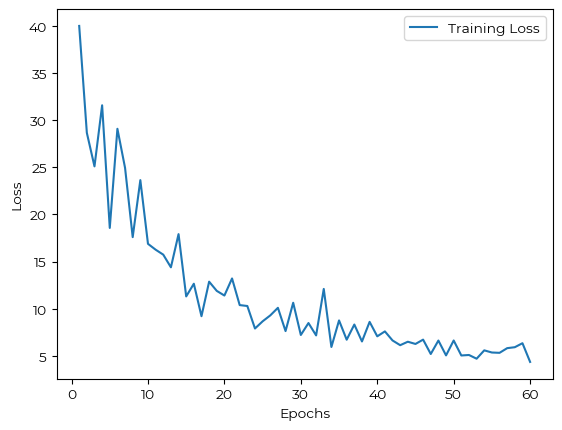

2023-08-24 12:09:33.565549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 158ms/step


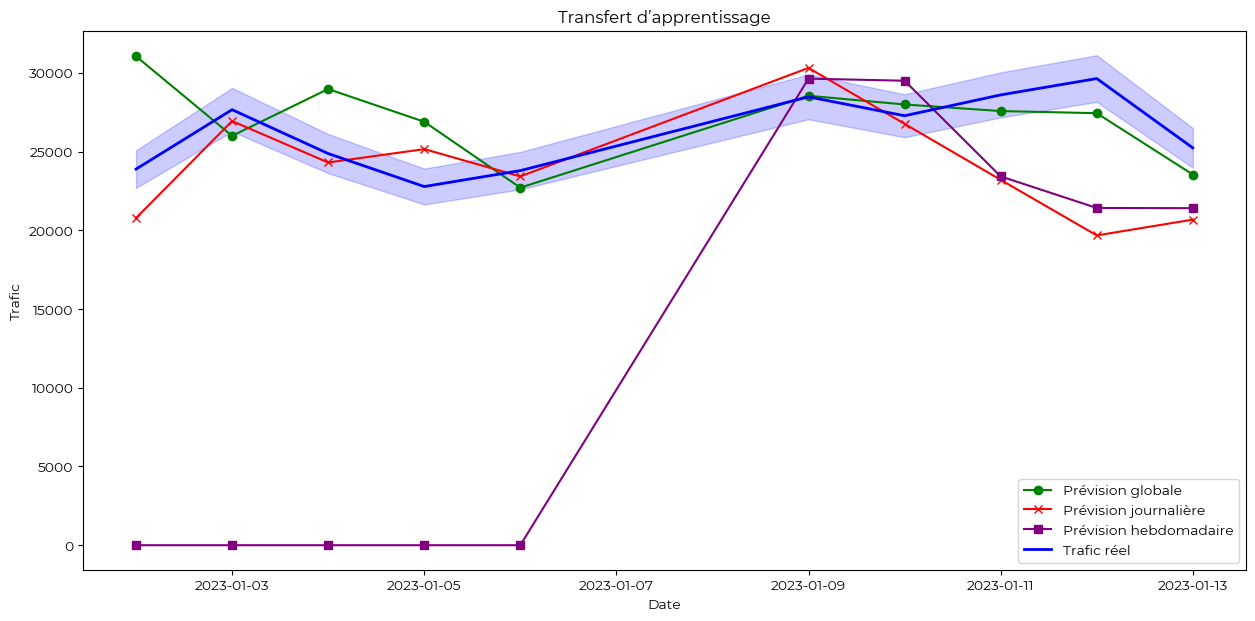

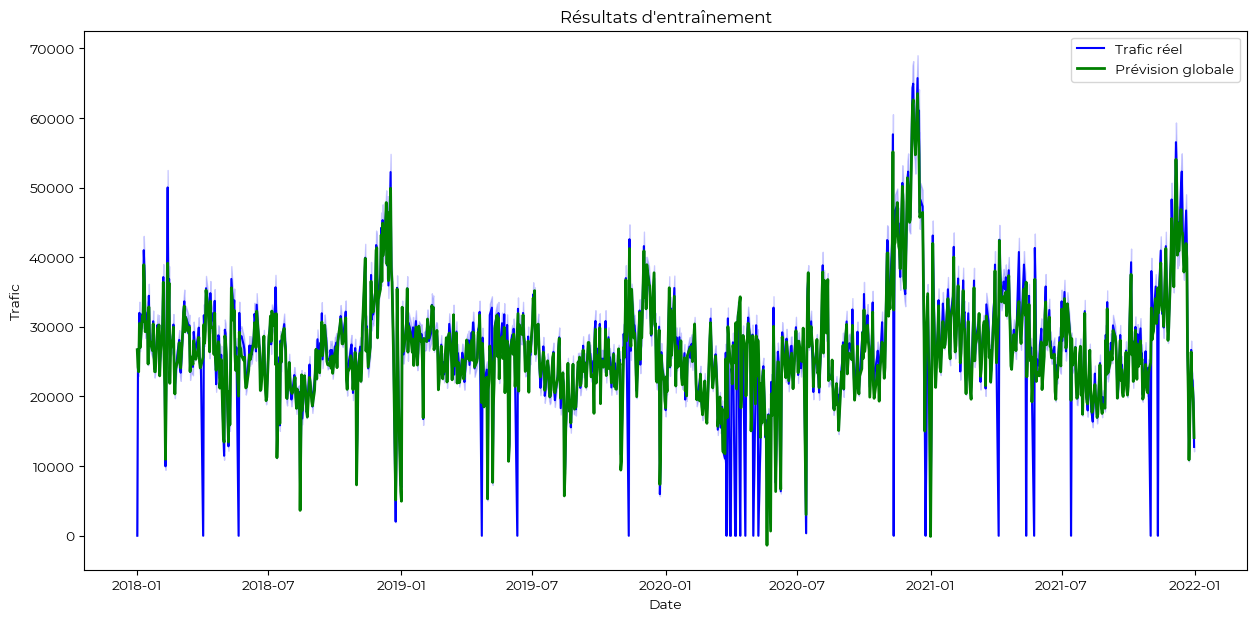

Train MAPE Prévision globale - Average: 4.79% | Max: 743.56%
Test MAPE Prévision globale - Average: 9.57% | Max: 30.01%
Test MAPE Prévision journalière - Average: 10.87% | Max: 33.61%
Test MAPE Prévision hebdomadaire - Average: 57.32% | Max: 100.00%
64 14 l1 0.1 None
Epoch 1/60


2023-08-24 12:09:45.391789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 5s 90ms/step - loss: 154.2804 - custom_mape: 48.2465 - custom_mae: 16.9685
Epoch 2/60
33/33 [==============================] - 1s 19ms/step - loss: 101.3412 - custom_mape: 29.6155 - custom_mae: 8.9711
Epoch 3/60
33/33 [==============================] - 1s 24ms/step - loss: 76.3922 - custom_mape: 24.5238 - custom_mae: 8.3327
Epoch 4/60
33/33 [==============================] - 0s 9ms/step - loss: 70.0681 - custom_mape: 28.6040 - custom_mae: 9.4217
Epoch 5/60
33/33 [==============================] - 1s 24ms/step - loss: 60.9206 - custom_mape: 26.0284 - custom_mae: 9.3783
Epoch 6/60
33/33 [==============================] - 0s 12ms/step - loss: 57.9810 - custom_mape: 27.1626 - custom_mae: 9.5668
Epoch 7/60
33/33 [==============================] - 0s 10ms/step - loss: 52.7917 - custom_mape: 25.9874 - custom_mae: 8.7785
Epoch 8/60
33/33 [==============================] - 1s 19ms/step - loss: 46.8179 - custom_mape: 22.3918 - custom_mae: 7.9642
Epoch 9/6

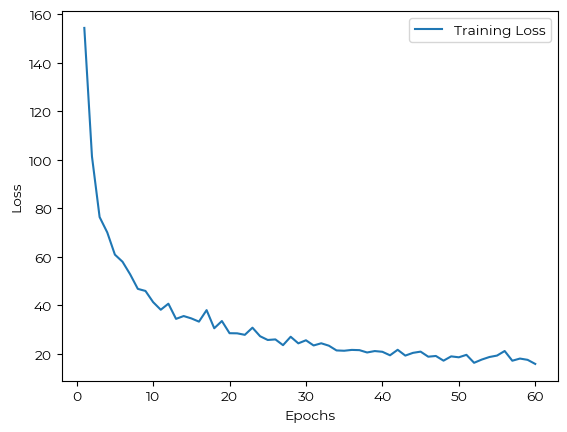

 1/33 [..............................] - ETA: 7s

2023-08-24 12:10:10.016725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 159ms/step


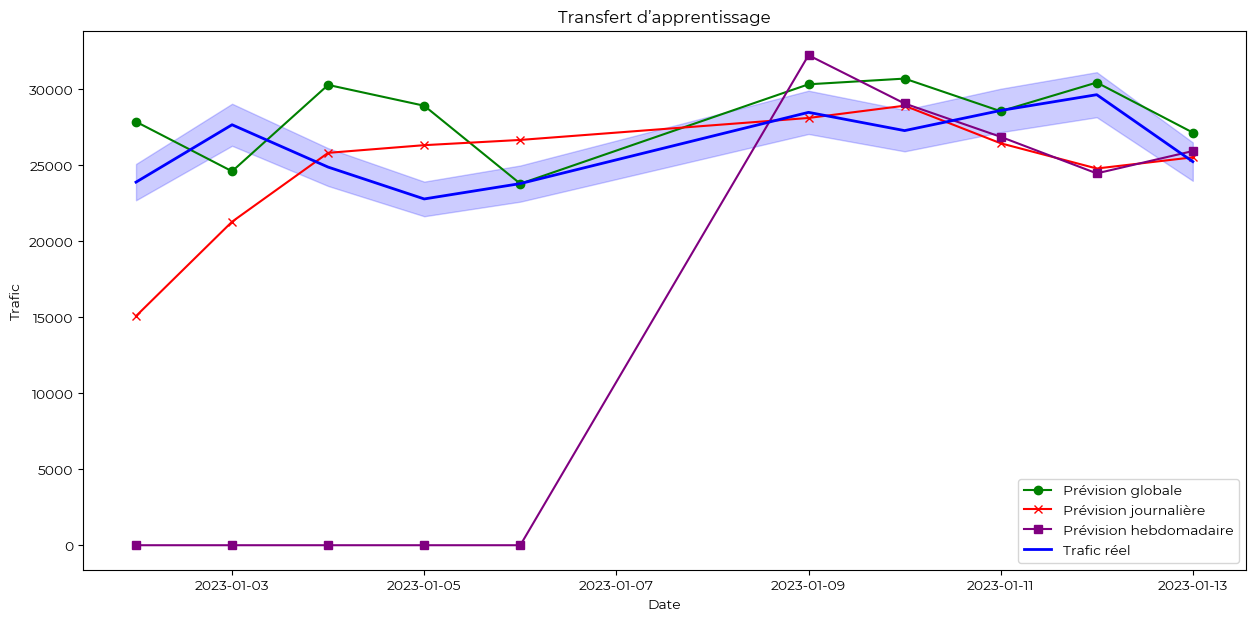

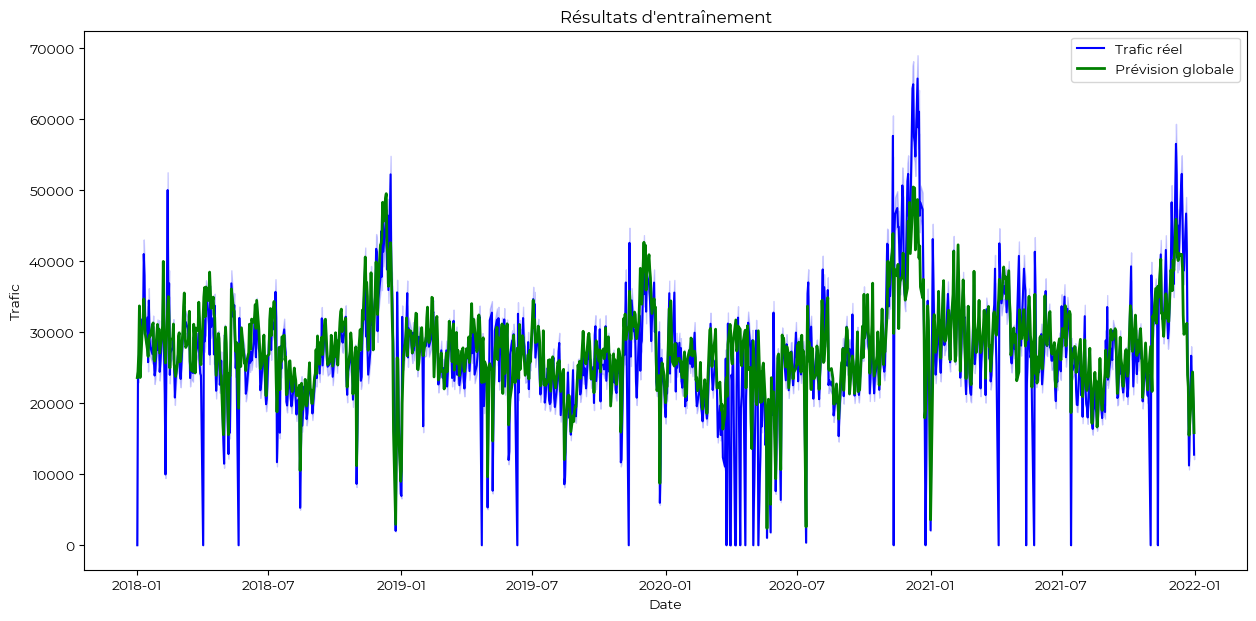

Train MAPE Prévision globale - Average: 11.30% | Max: 617.80%
Test MAPE Prévision globale - Average: 10.59% | Max: 26.92%
Test MAPE Prévision journalière - Average: 12.37% | Max: 36.89%
Test MAPE Prévision hebdomadaire - Average: 54.60% | Max: 100.00%
64 14 l1 0.01 None
Epoch 1/60


2023-08-24 12:10:19.905400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 5s 89ms/step - loss: 62.6102 - custom_mape: 50.5165 - custom_mae: 17.7569
Epoch 2/60
33/33 [==============================] - 0s 13ms/step - loss: 38.9699 - custom_mape: 28.6355 - custom_mae: 8.6863
Epoch 3/60
33/33 [==============================] - 0s 11ms/step - loss: 36.5227 - custom_mape: 27.0128 - custom_mae: 8.3443
Epoch 4/60
33/33 [==============================] - 0s 14ms/step - loss: 35.6288 - custom_mape: 26.7048 - custom_mae: 8.8651
Epoch 5/60
33/33 [==============================] - 1s 34ms/step - loss: 27.9455 - custom_mape: 19.5915 - custom_mae: 7.1164
Epoch 6/60
33/33 [==============================] - 0s 11ms/step - loss: 32.6796 - custom_mape: 24.5511 - custom_mae: 7.3710
Epoch 7/60
33/33 [==============================] - 0s 8ms/step - loss: 27.5308 - custom_mape: 19.7710 - custom_mae: 7.0671
Epoch 8/60
33/33 [==============================] - 1s 20ms/step - loss: 25.0557 - custom_mape: 17.6160 - custom_mae: 5.8868
Epoch 9/60


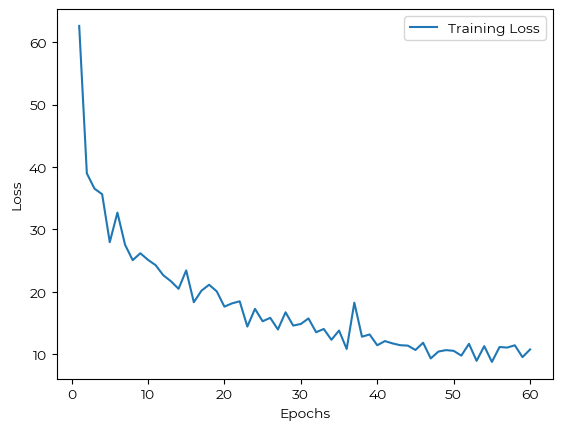

2023-08-24 12:10:43.274014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 175ms/step


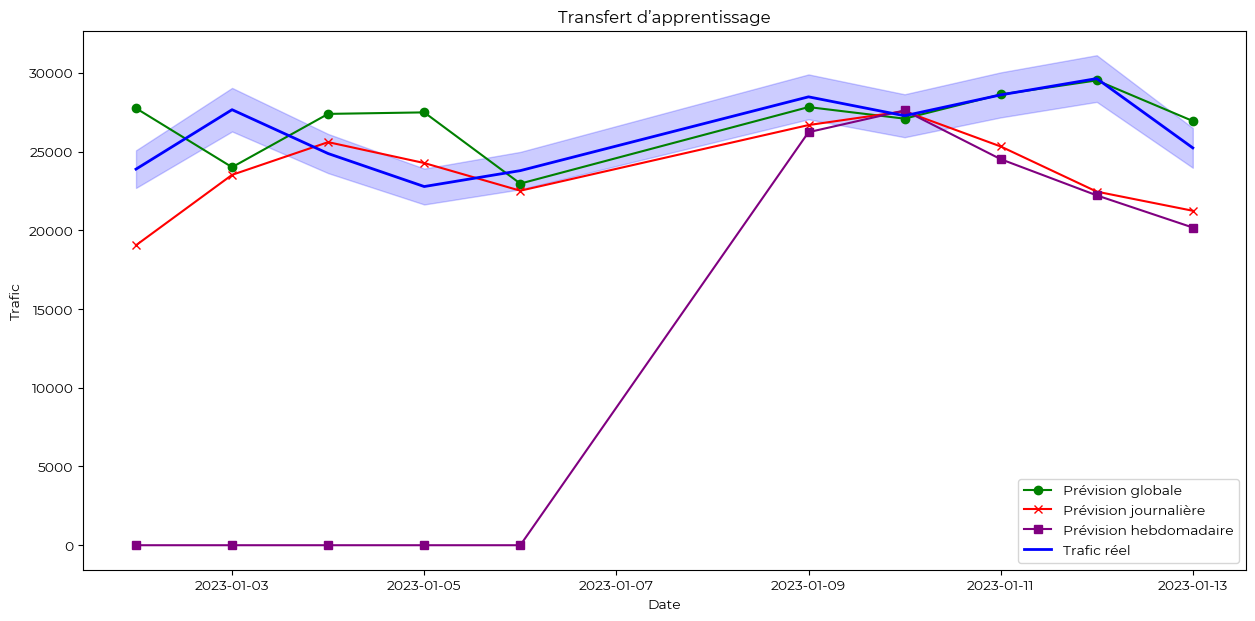

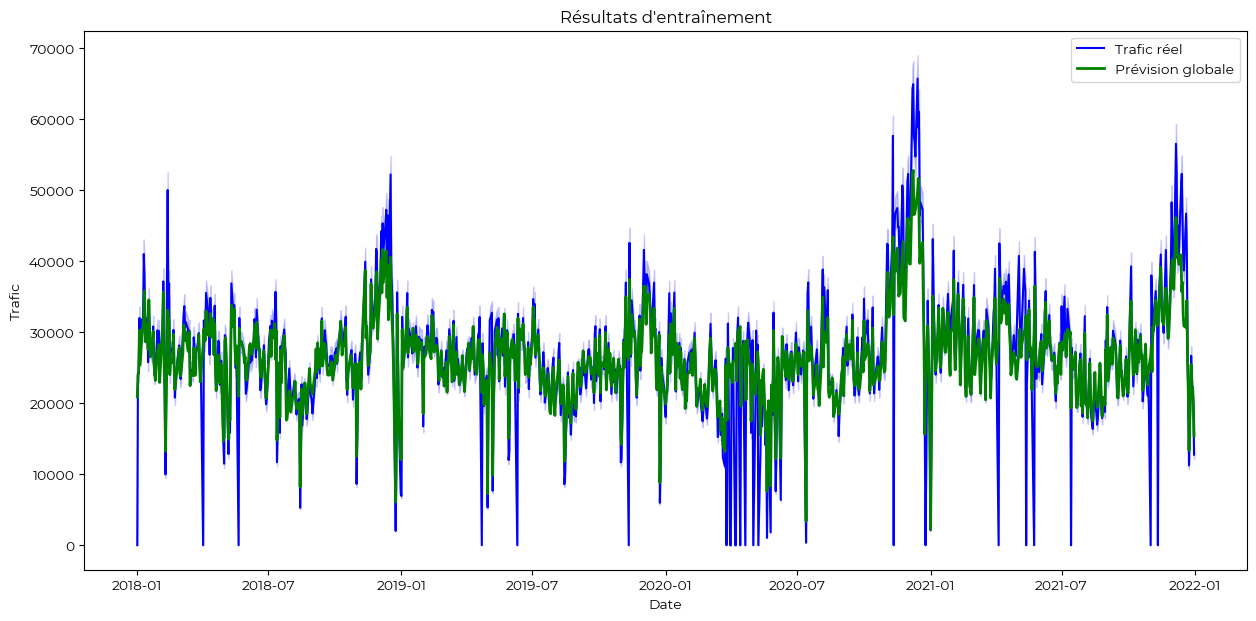

Train MAPE Prévision globale - Average: 7.92% | Max: 840.51%
Test MAPE Prévision globale - Average: 7.39% | Max: 20.67%
Test MAPE Prévision journalière - Average: 10.89% | Max: 24.23%
Test MAPE Prévision hebdomadaire - Average: 56.85% | Max: 100.00%
64 14 l1 0.001 None
Epoch 1/60


2023-08-24 12:10:53.376807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 5s 81ms/step - loss: 39.2682 - custom_mape: 37.9370 - custom_mae: 10.8831
Epoch 2/60
33/33 [==============================] - 1s 31ms/step - loss: 30.9193 - custom_mape: 30.9691 - custom_mae: 9.4609
Epoch 3/60
33/33 [==============================] - 1s 23ms/step - loss: 34.4059 - custom_mape: 33.2050 - custom_mae: 10.1689
Epoch 4/60
33/33 [==============================] - 0s 12ms/step - loss: 31.0352 - custom_mape: 29.8512 - custom_mae: 10.1782
Epoch 5/60
33/33 [==============================] - 0s 10ms/step - loss: 23.0317 - custom_mape: 22.4678 - custom_mae: 7.8702
Epoch 6/60
33/33 [==============================] - 1s 23ms/step - loss: 31.6290 - custom_mape: 30.5544 - custom_mae: 10.1843
Epoch 7/60
33/33 [==============================] - 0s 10ms/step - loss: 22.5405 - custom_mape: 21.6387 - custom_mae: 7.3524
Epoch 8/60
33/33 [==============================] - 0s 7ms/step - loss: 20.0996 - custom_mape: 19.1263 - custom_mae: 6.5704
Epoch 9/

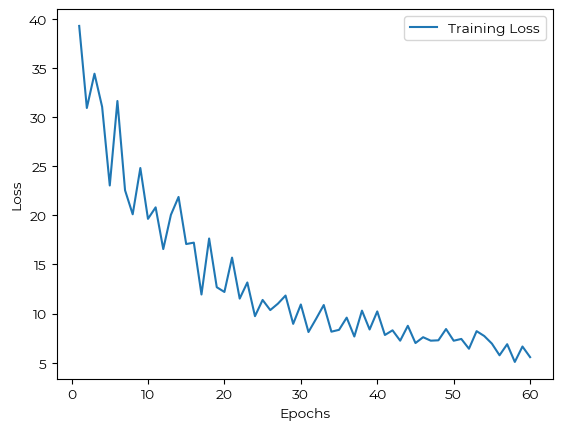

2023-08-24 12:11:16.764847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 194ms/step


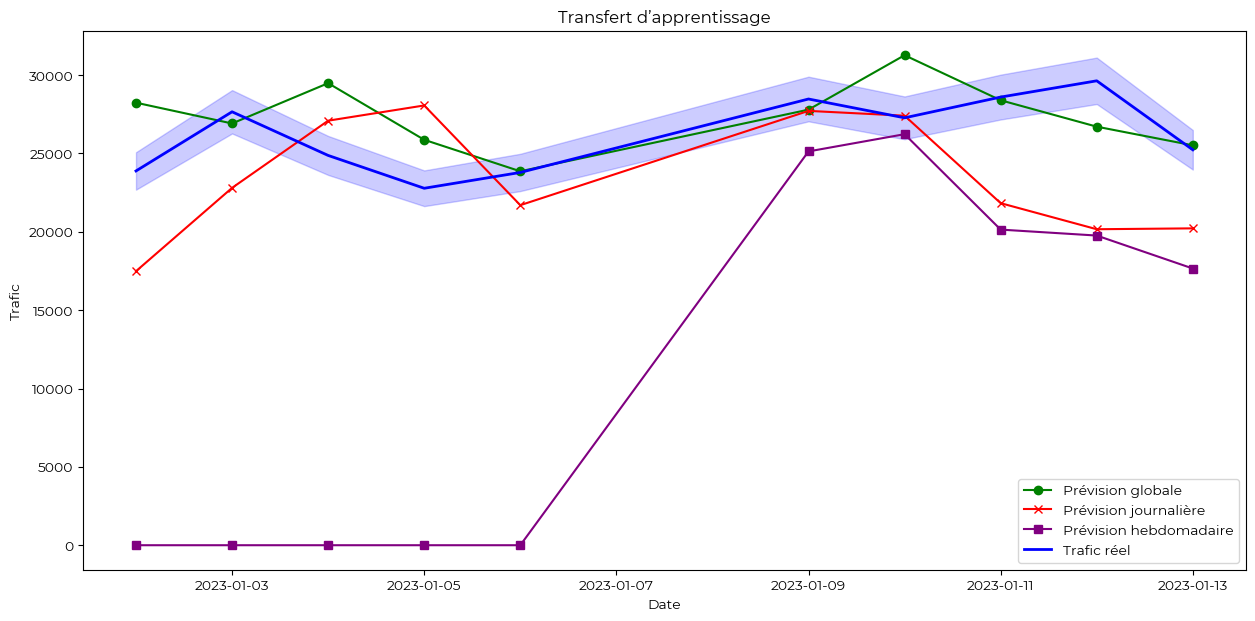

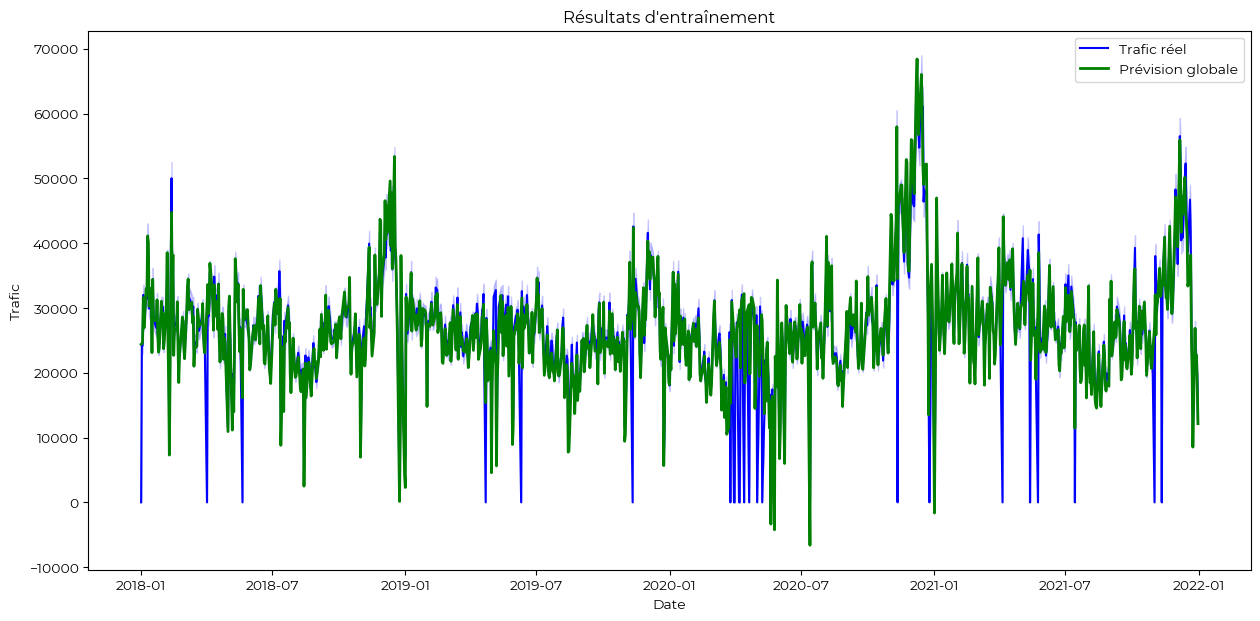

Train MAPE Prévision globale - Average: 7.04% | Max: 1939.89%
Test MAPE Prévision globale - Average: 8.21% | Max: 18.54%
Test MAPE Prévision journalière - Average: 16.39% | Max: 31.96%
Test MAPE Prévision hebdomadaire - Average: 60.85% | Max: 100.00%
64 14 l1 0.0001 None
Epoch 1/60


2023-08-24 12:11:53.342761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 8s 151ms/step - loss: 57.2604 - custom_mape: 56.9268 - custom_mae: 20.4987
Epoch 2/60
33/33 [==============================] - 2s 52ms/step - loss: 35.0614 - custom_mape: 34.8626 - custom_mae: 10.4006
Epoch 3/60
33/33 [==============================] - 0s 10ms/step - loss: 29.6383 - custom_mape: 29.4972 - custom_mae: 10.4315
Epoch 4/60
33/33 [==============================] - 1s 16ms/step - loss: 25.6946 - custom_mape: 25.5280 - custom_mae: 7.9930
Epoch 5/60
33/33 [==============================] - 0s 10ms/step - loss: 25.1429 - custom_mape: 25.0464 - custom_mae: 7.5168
Epoch 6/60
33/33 [==============================] - 0s 8ms/step - loss: 19.6334 - custom_mape: 19.4773 - custom_mae: 6.8689
Epoch 7/60
33/33 [==============================] - 0s 11ms/step - loss: 24.2577 - custom_mape: 24.1262 - custom_mae: 7.1509
Epoch 8/60
33/33 [==============================] - 0s 8ms/step - loss: 19.6870 - custom_mape: 19.4954 - custom_mae: 6.6434
Epoch 9/6

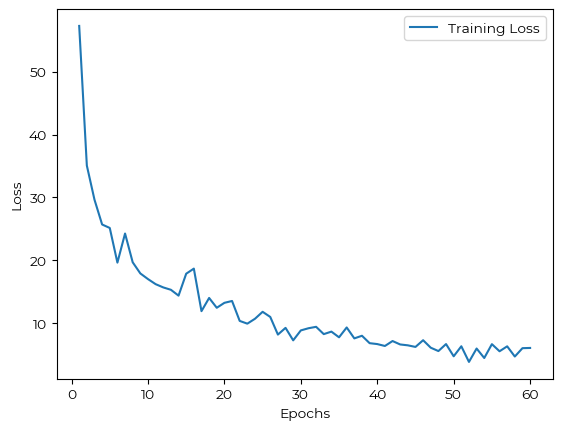

2023-08-24 12:12:20.979442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 165ms/step


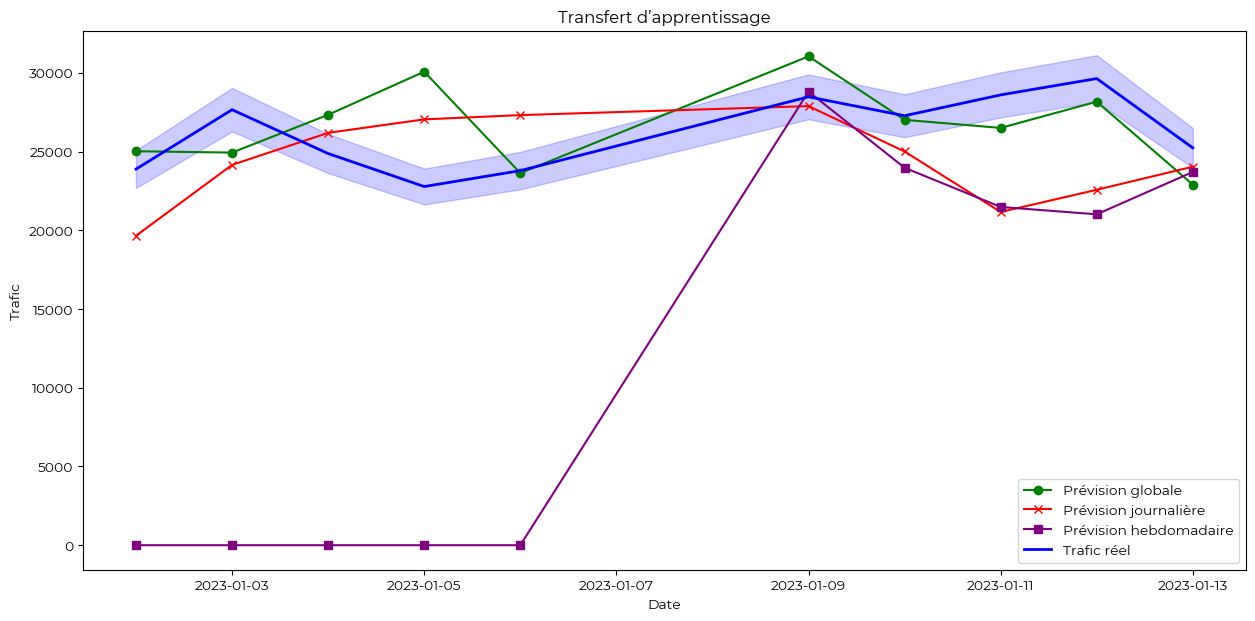

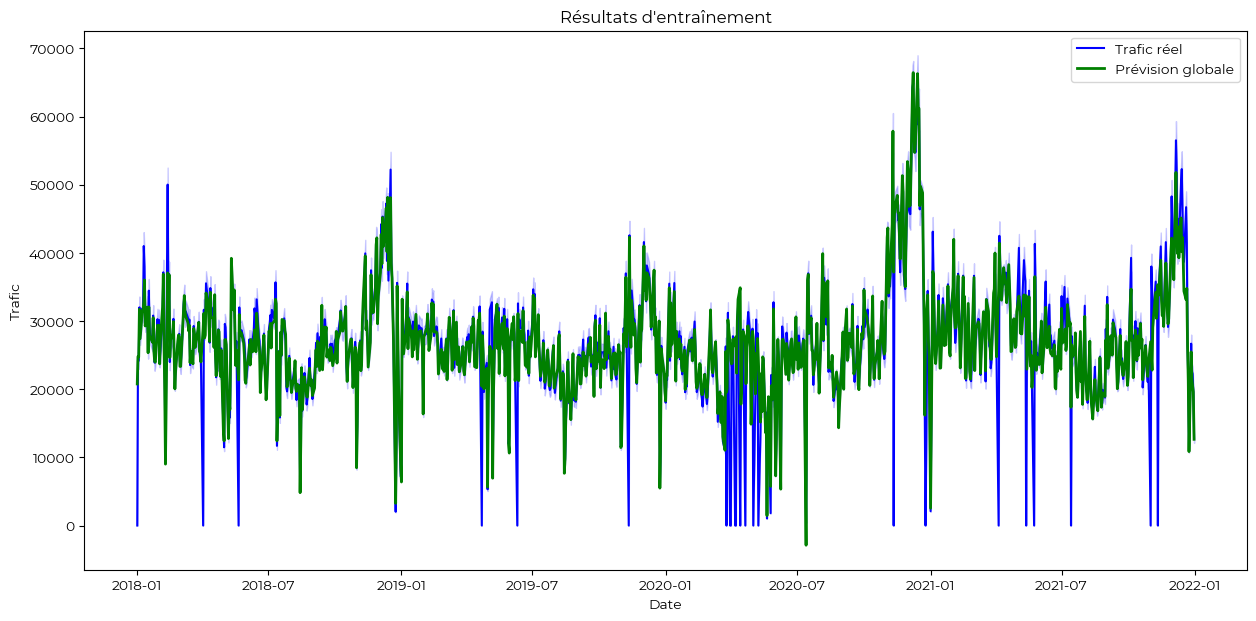

Train MAPE Prévision globale - Average: 4.57% | Max: 903.13%
Test MAPE Prévision globale - Average: 8.87% | Max: 32.02%
Test MAPE Prévision journalière - Average: 13.42% | Max: 26.01%
Test MAPE Prévision hebdomadaire - Average: 57.33% | Max: 100.00%
64 14 l2 None 0
Epoch 1/60


2023-08-24 12:12:34.230151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 6s 116ms/step - loss: 55.5172 - custom_mape: 55.1396 - custom_mae: 18.7822
Epoch 2/60
33/33 [==============================] - 1s 15ms/step - loss: 31.7408 - custom_mape: 31.5856 - custom_mae: 9.8825
Epoch 3/60
33/33 [==============================] - 1s 36ms/step - loss: 28.2113 - custom_mape: 28.1878 - custom_mae: 9.3685
Epoch 4/60
33/33 [==============================] - 1s 24ms/step - loss: 30.9140 - custom_mape: 30.8265 - custom_mae: 8.9476
Epoch 5/60
33/33 [==============================] - 5s 145ms/step - loss: 26.6212 - custom_mape: 26.6406 - custom_mae: 9.8606
Epoch 6/60
33/33 [==============================] - 0s 9ms/step - loss: 24.4534 - custom_mape: 24.4359 - custom_mae: 7.7611
Epoch 7/60
33/33 [==============================] - 0s 13ms/step - loss: 22.9139 - custom_mape: 22.9066 - custom_mae: 7.5593
Epoch 8/60
33/33 [==============================] - 0s 12ms/step - loss: 19.2994 - custom_mape: 19.2434 - custom_mae: 6.6760
Epoch 9/6

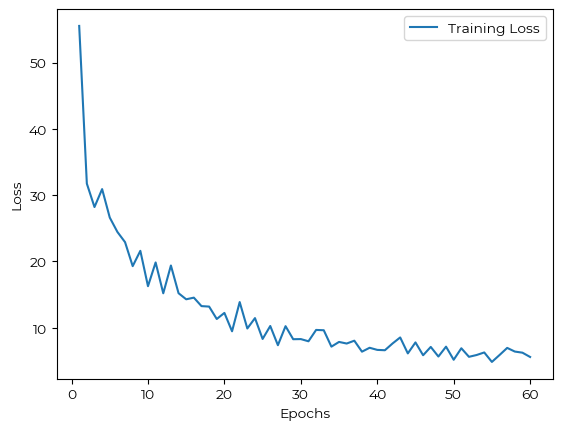

2023-08-24 12:13:06.449372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 240ms/step


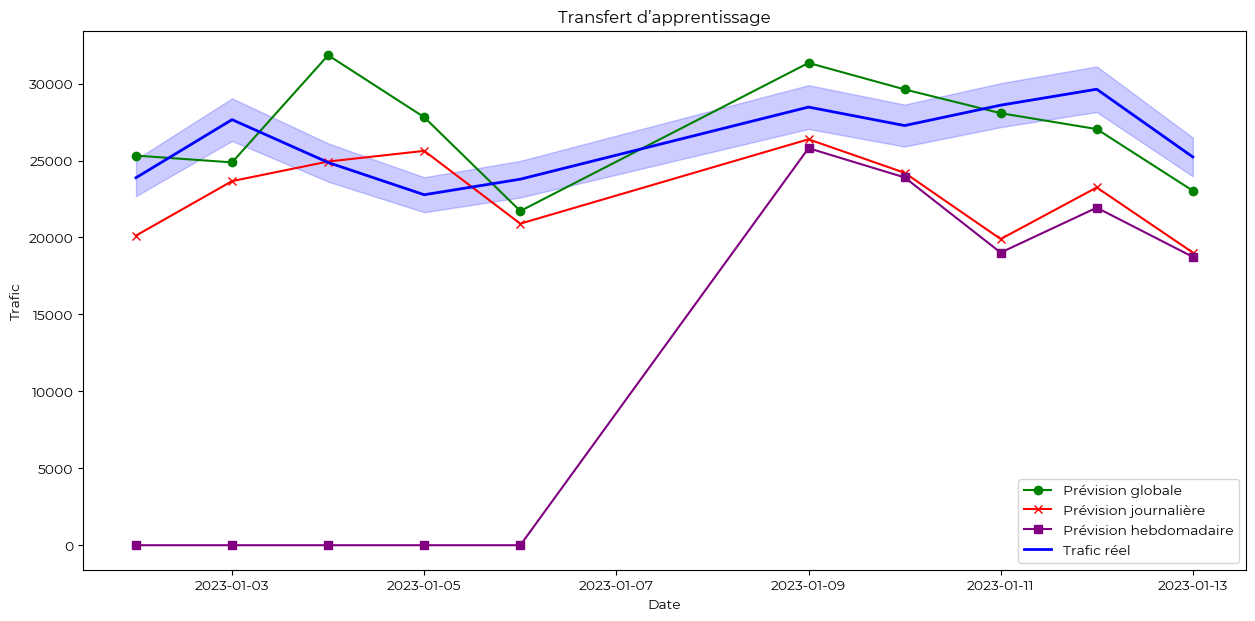

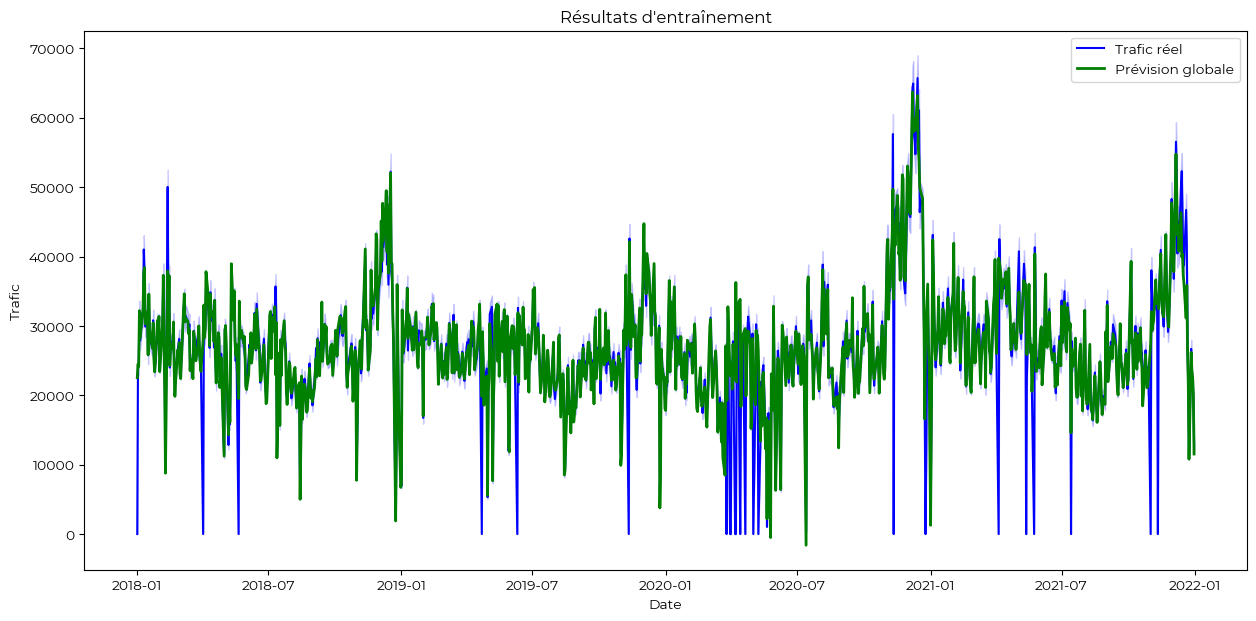

Train MAPE Prévision globale - Average: 4.16% | Max: 547.25%
Test MAPE Prévision globale - Average: 11.29% | Max: 28.03%
Test MAPE Prévision journalière - Average: 15.03% | Max: 30.42%
Test MAPE Prévision hebdomadaire - Average: 60.69% | Max: 100.00%
64 14 l2 None 0.1
Epoch 1/60


2023-08-24 12:13:18.756676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 7s 149ms/step - loss: 50.4608 - custom_mape: 44.0350 - custom_mae: 13.3803
Epoch 2/60
33/33 [==============================] - 3s 78ms/step - loss: 32.6886 - custom_mape: 27.2185 - custom_mae: 8.8153
Epoch 3/60
33/33 [==============================] - 3s 90ms/step - loss: 32.6793 - custom_mape: 30.3132 - custom_mae: 8.2154
Epoch 4/60
33/33 [==============================] - 3s 76ms/step - loss: 42.5564 - custom_mape: 37.7766 - custom_mae: 11.9357
Epoch 5/60
33/33 [==============================] - 2s 68ms/step - loss: 35.0557 - custom_mape: 30.4616 - custom_mae: 10.3813
Epoch 6/60
33/33 [==============================] - 3s 77ms/step - loss: 28.1865 - custom_mape: 23.8407 - custom_mae: 8.9444
Epoch 7/60
33/33 [==============================] - 2s 68ms/step - loss: 28.9184 - custom_mape: 24.6234 - custom_mae: 7.8623
Epoch 8/60
33/33 [==============================] - 2s 66ms/step - loss: 29.0063 - custom_mape: 24.9054 - custom_mae: 7.8635
Epoch 9

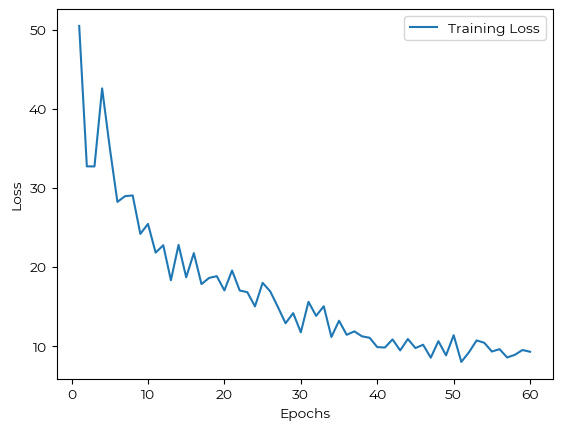

2023-08-24 12:15:46.531203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 143ms/step


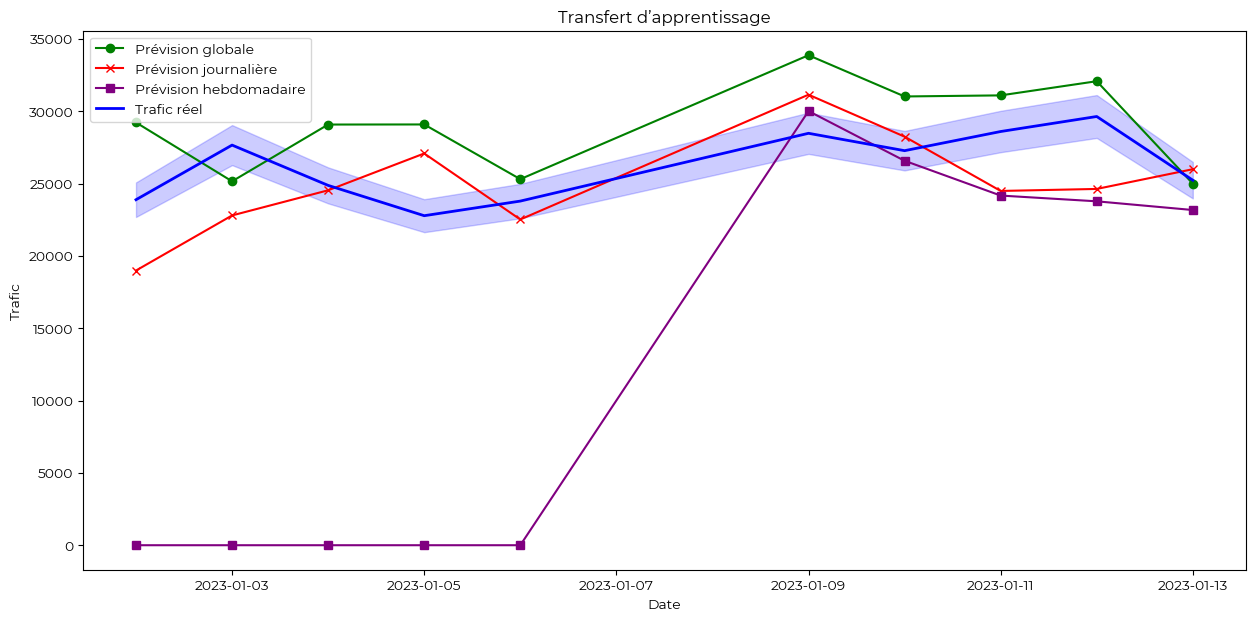

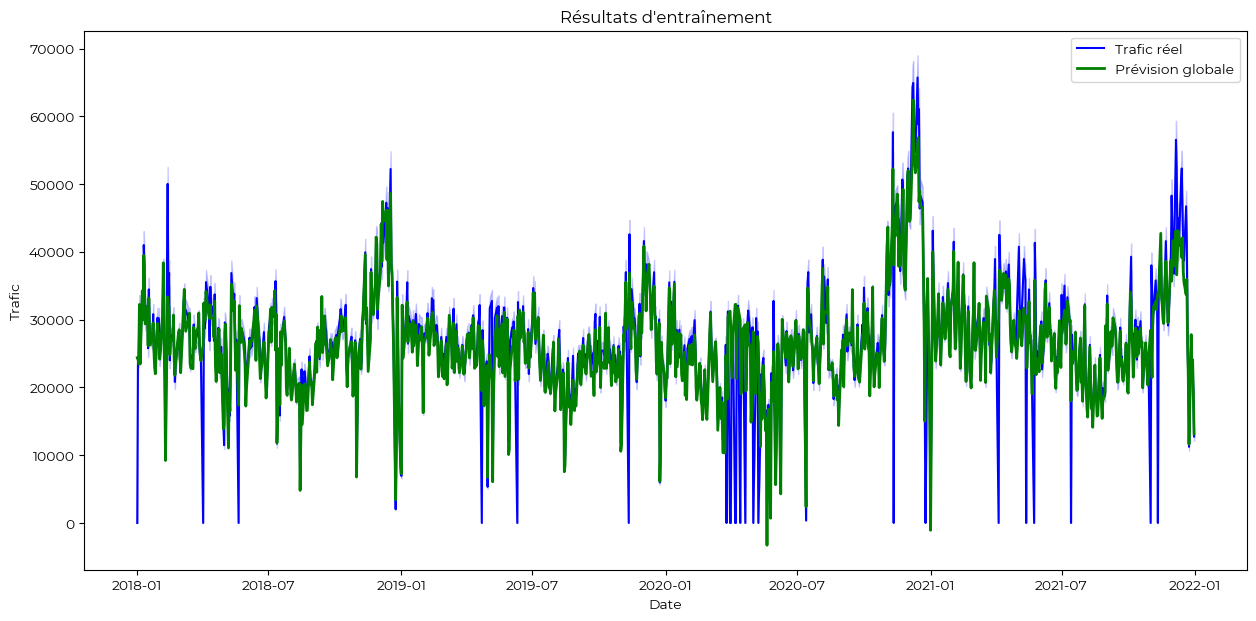

Train MAPE Prévision globale - Average: 5.83% | Max: 562.48%
Test MAPE Prévision globale - Average: 13.30% | Max: 27.69%
Test MAPE Prévision journalière - Average: 11.09% | Max: 20.50%
Test MAPE Prévision hebdomadaire - Average: 55.14% | Max: 100.00%
64 14 l2 None 0.01
Epoch 1/60


2023-08-24 12:16:42.436361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 9s 181ms/step - loss: 41.5618 - custom_mape: 40.7505 - custom_mae: 12.5018
Epoch 2/60
33/33 [==============================] - 4s 130ms/step - loss: 28.1426 - custom_mape: 27.4794 - custom_mae: 9.3195
Epoch 3/60
33/33 [==============================] - 2s 71ms/step - loss: 27.8174 - custom_mape: 27.1902 - custom_mae: 8.5844
Epoch 4/60
33/33 [==============================] - 2s 73ms/step - loss: 27.1235 - custom_mape: 26.4524 - custom_mae: 8.2847
Epoch 5/60
33/33 [==============================] - 3s 87ms/step - loss: 23.1659 - custom_mape: 22.5006 - custom_mae: 8.1304
Epoch 6/60
33/33 [==============================] - 2s 69ms/step - loss: 26.4747 - custom_mape: 25.7836 - custom_mae: 7.9753
Epoch 7/60
33/33 [==============================] - 2s 67ms/step - loss: 20.5916 - custom_mape: 20.0117 - custom_mae: 7.4741
Epoch 8/60
33/33 [==============================] - 2s 68ms/step - loss: 20.0854 - custom_mape: 19.4639 - custom_mae: 6.6141
Epoch 9/

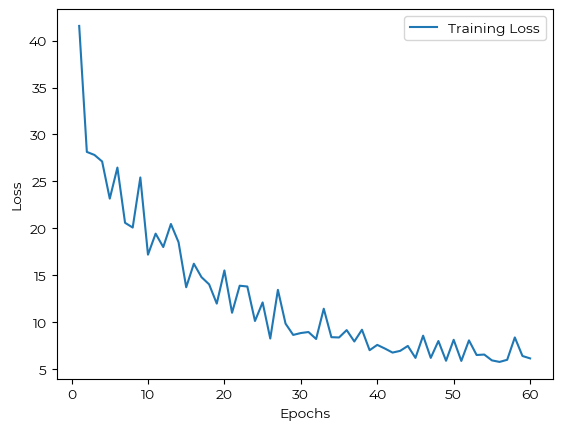

2023-08-24 12:19:09.876117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 134ms/step


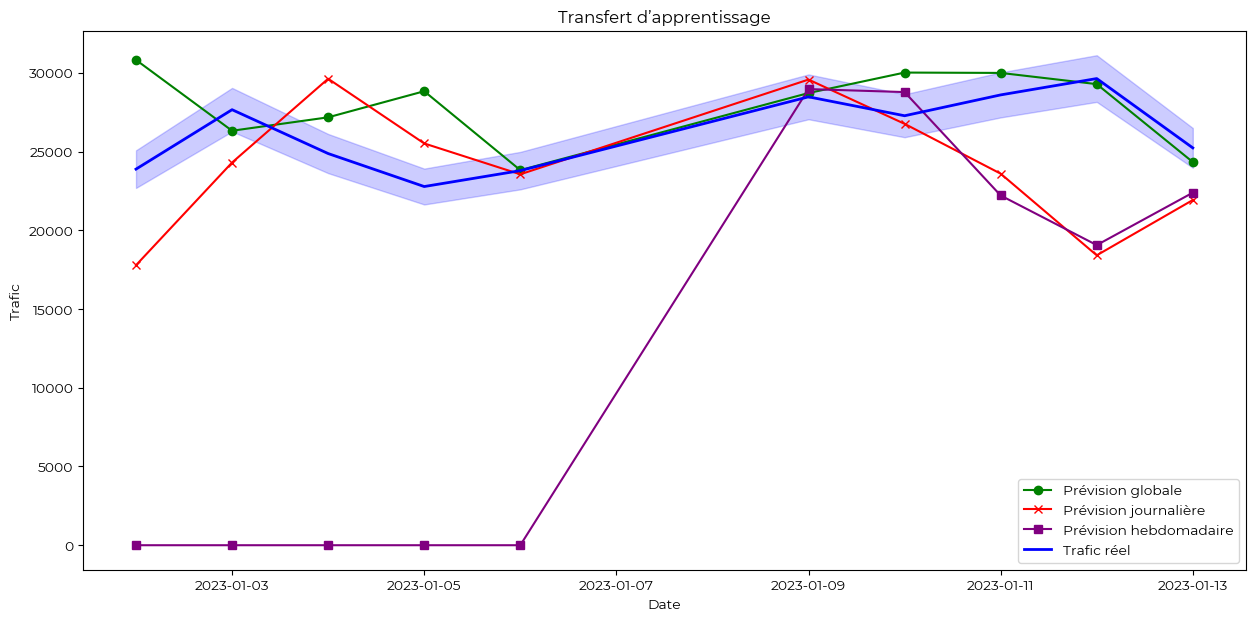

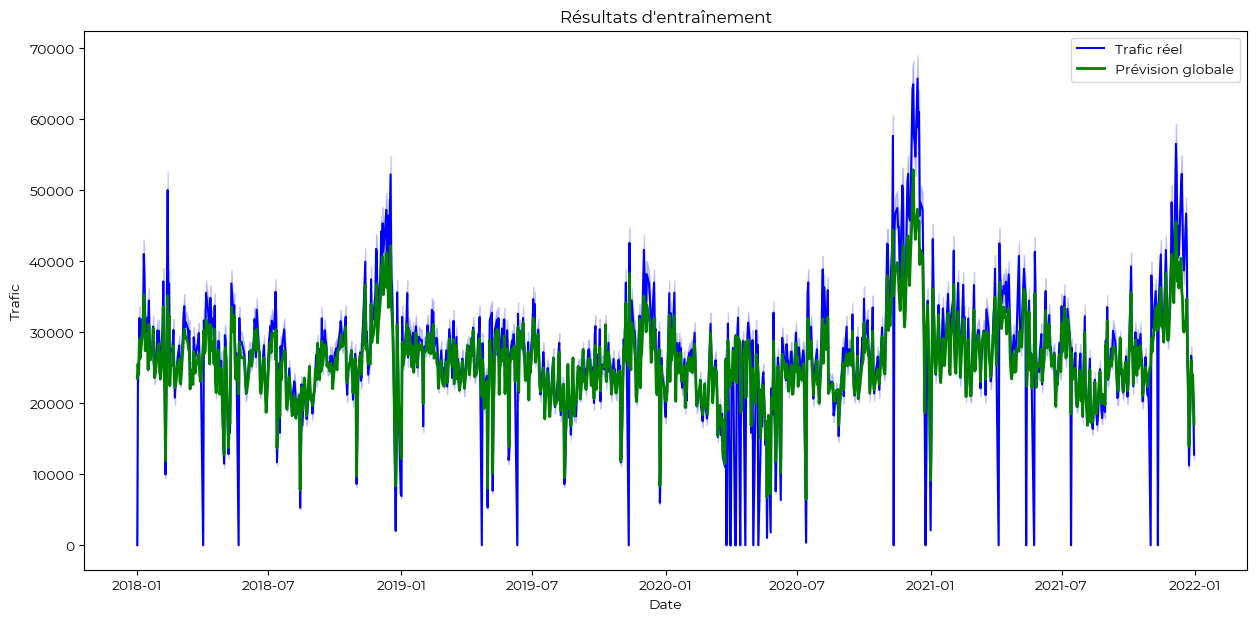

Train MAPE Prévision globale - Average: 9.76% | Max: 1706.72%
Test MAPE Prévision globale - Average: 9.04% | Max: 29.04%
Test MAPE Prévision journalière - Average: 14.40% | Max: 37.88%
Test MAPE Prévision hebdomadaire - Average: 57.65% | Max: 100.00%
64 14 l2 None 0.001
Epoch 1/60


2023-08-24 12:19:41.472246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 9s 213ms/step - loss: 39.8035 - custom_mape: 39.5380 - custom_mae: 11.7363
Epoch 2/60
33/33 [==============================] - 4s 106ms/step - loss: 31.2211 - custom_mape: 31.0980 - custom_mae: 9.7780
Epoch 3/60
33/33 [==============================] - 2s 69ms/step - loss: 30.8041 - custom_mape: 30.6103 - custom_mae: 9.9834
Epoch 4/60
33/33 [==============================] - 2s 70ms/step - loss: 28.7437 - custom_mape: 28.5943 - custom_mae: 9.0203
Epoch 5/60
33/33 [==============================] - 2s 74ms/step - loss: 21.9720 - custom_mape: 21.9432 - custom_mae: 8.0087
Epoch 6/60
33/33 [==============================] - 2s 68ms/step - loss: 24.2129 - custom_mape: 24.1738 - custom_mae: 7.2454
Epoch 7/60
33/33 [==============================] - 2s 66ms/step - loss: 22.6685 - custom_mape: 22.5672 - custom_mae: 8.2758
Epoch 8/60
33/33 [==============================] - 2s 70ms/step - loss: 24.0040 - custom_mape: 23.8141 - custom_mae: 7.1940
Epoch 9/

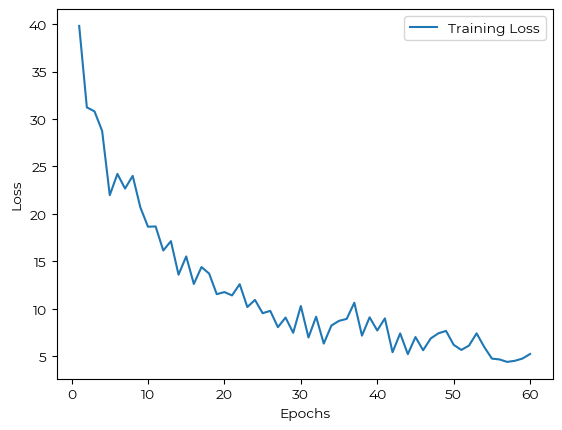

2023-08-24 12:22:09.025025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 145ms/step


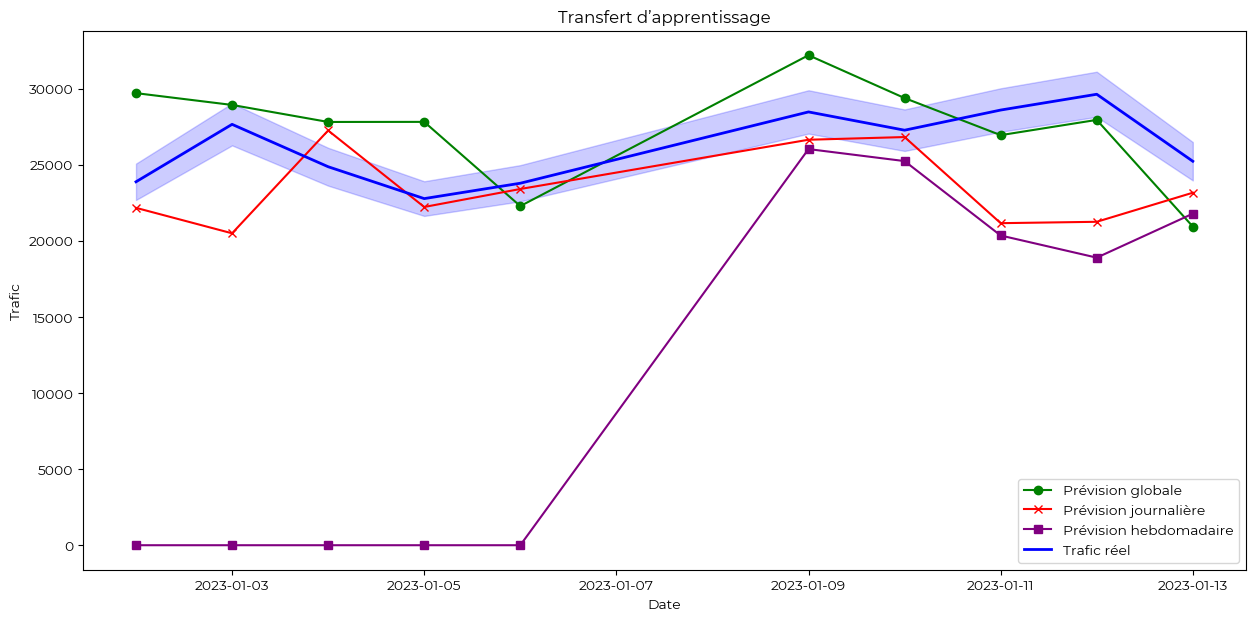

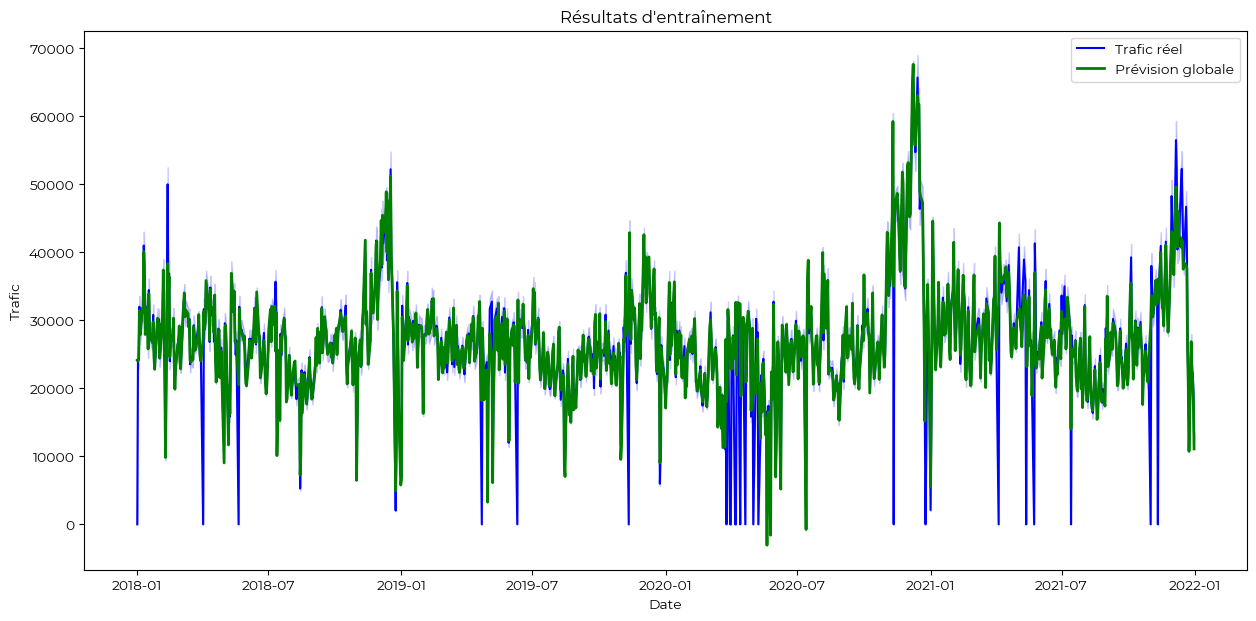

Train MAPE Prévision globale - Average: 4.17% | Max: 397.24%
Test MAPE Prévision globale - Average: 11.86% | Max: 24.39%
Test MAPE Prévision journalière - Average: 11.72% | Max: 28.28%
Test MAPE Prévision hebdomadaire - Average: 59.47% | Max: 100.00%
64 14 l2 None 0.0001
Epoch 1/60


2023-08-24 12:22:38.627938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 8s 182ms/step - loss: 42.0472 - custom_mape: 41.8003 - custom_mae: 12.0560
Epoch 2/60
33/33 [==============================] - 3s 90ms/step - loss: 28.4624 - custom_mape: 28.3410 - custom_mae: 9.2909
Epoch 3/60
33/33 [==============================] - 2s 74ms/step - loss: 30.5137 - custom_mape: 30.4649 - custom_mae: 9.1006
Epoch 4/60
33/33 [==============================] - 2s 75ms/step - loss: 27.1730 - custom_mape: 27.0946 - custom_mae: 9.2823
Epoch 5/60
33/33 [==============================] - 3s 86ms/step - loss: 22.3550 - custom_mape: 22.3702 - custom_mae: 7.6720
Epoch 6/60
33/33 [==============================] - 2s 70ms/step - loss: 22.5398 - custom_mape: 22.5571 - custom_mae: 7.0639
Epoch 7/60
33/33 [==============================] - 2s 70ms/step - loss: 19.7315 - custom_mape: 19.6239 - custom_mae: 7.3590
Epoch 8/60
33/33 [==============================] - 2s 66ms/step - loss: 19.9719 - custom_mape: 19.9766 - custom_mae: 5.9893
Epoch 9/6

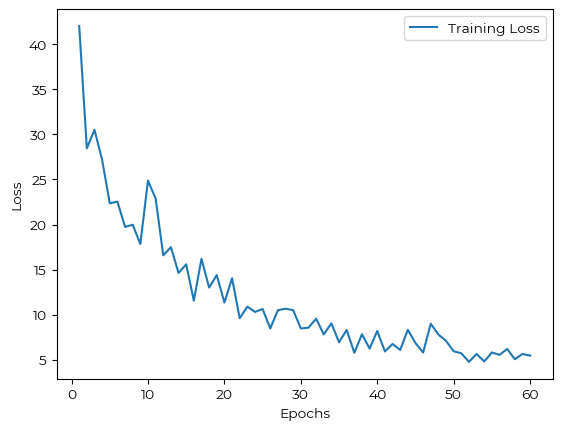

2023-08-24 12:25:22.051386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 314ms/step


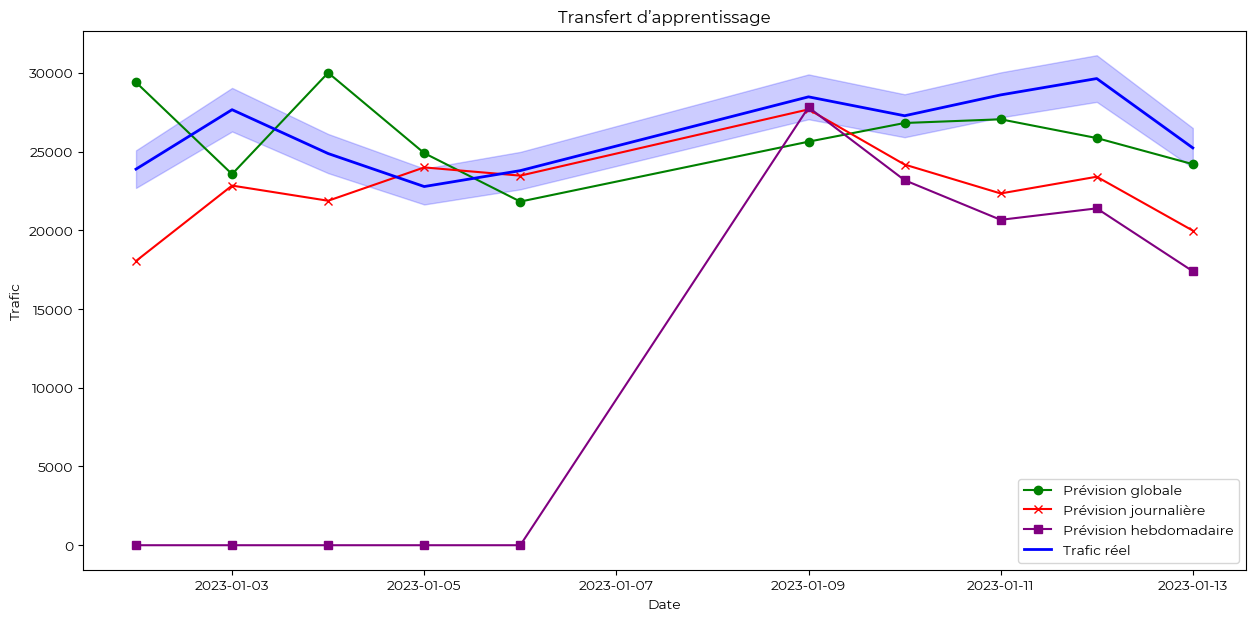

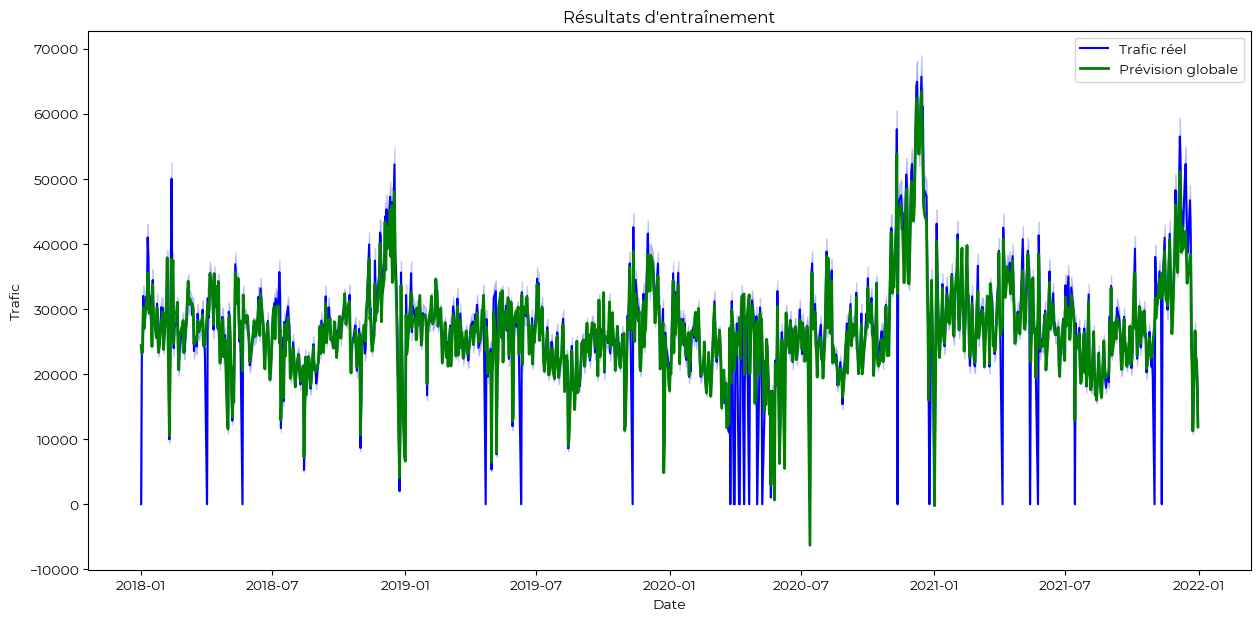

Train MAPE Prévision globale - Average: 6.11% | Max: 1851.45%
Test MAPE Prévision globale - Average: 11.00% | Max: 23.08%
Test MAPE Prévision journalière - Average: 13.85% | Max: 24.42%
Test MAPE Prévision hebdomadaire - Average: 60.39% | Max: 100.00%
64 14 l1_l2 0 0
Epoch 1/60


2023-08-24 12:26:41.408742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 36s 173ms/step - loss: 44.9431 - custom_mape: 45.1903 - custom_mae: 14.0937
Epoch 2/60
33/33 [==============================] - 2s 47ms/step - loss: 29.9902 - custom_mape: 29.9586 - custom_mae: 9.4811
Epoch 3/60
33/33 [==============================] - 2s 51ms/step - loss: 27.0329 - custom_mape: 26.9473 - custom_mae: 8.6709
Epoch 4/60
33/33 [==============================] - 1s 24ms/step - loss: 33.3767 - custom_mape: 33.2673 - custom_mae: 10.8752
Epoch 5/60
33/33 [==============================] - 4s 128ms/step - loss: 21.9430 - custom_mape: 22.0245 - custom_mae: 8.0736
Epoch 6/60
33/33 [==============================] - 1s 39ms/step - loss: 21.9299 - custom_mape: 21.8521 - custom_mae: 7.2058
Epoch 7/60
33/33 [==============================] - 2s 67ms/step - loss: 21.9172 - custom_mape: 21.8428 - custom_mae: 7.1010
Epoch 8/60
33/33 [==============================] - 5s 163ms/step - loss: 16.8222 - custom_mape: 16.7853 - custom_mae: 6.4813
Epoch

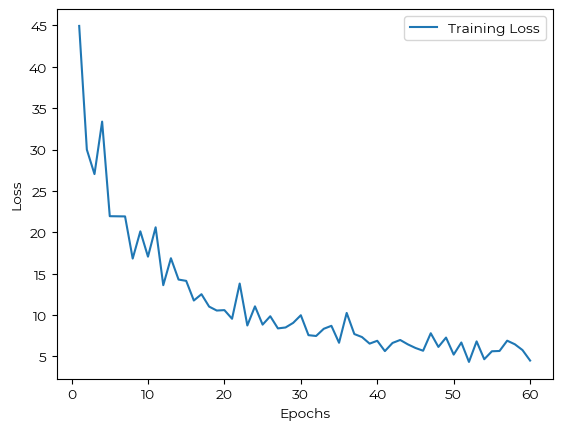

2023-08-24 12:27:29.950183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 231ms/step


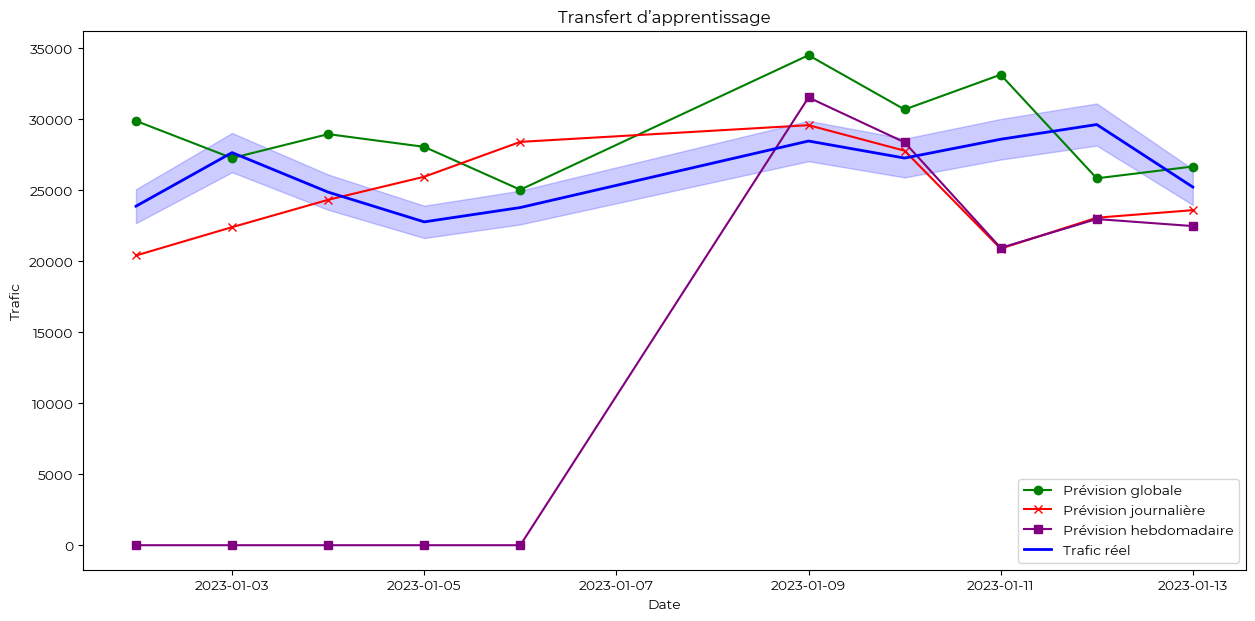

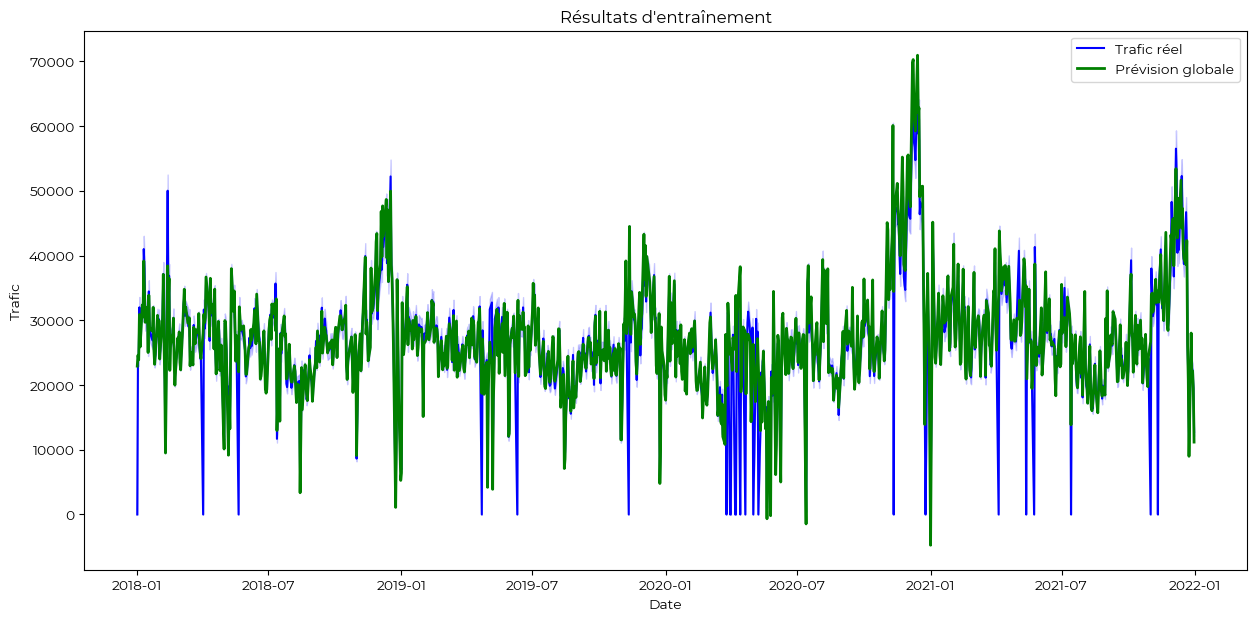

Train MAPE Prévision globale - Average: 4.79% | Max: 505.30%
Test MAPE Prévision globale - Average: 13.97% | Max: 25.15%
Test MAPE Prévision journalière - Average: 13.05% | Max: 26.94%
Test MAPE Prévision hebdomadaire - Average: 57.50% | Max: 100.00%
64 14 l1_l2 0 0.1
Epoch 1/60


2023-08-24 12:27:51.362806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 23s 514ms/step - loss: 51.8126 - custom_mape: 45.3884 - custom_mae: 14.4011
Epoch 2/60
33/33 [==============================] - 6s 172ms/step - loss: 37.3105 - custom_mape: 32.0808 - custom_mae: 9.4428
Epoch 3/60
33/33 [==============================] - 3s 83ms/step - loss: 31.8163 - custom_mape: 27.1796 - custom_mae: 9.3495
Epoch 4/60
33/33 [==============================] - 3s 78ms/step - loss: 29.9534 - custom_mape: 25.6318 - custom_mae: 8.2386
Epoch 5/60
33/33 [==============================] - 3s 90ms/step - loss: 31.3716 - custom_mape: 27.3504 - custom_mae: 8.5637
Epoch 6/60
33/33 [==============================] - 3s 96ms/step - loss: 29.9099 - custom_mape: 25.9660 - custom_mae: 9.6427
Epoch 7/60
33/33 [==============================] - 3s 99ms/step - loss: 27.6894 - custom_mape: 24.0998 - custom_mae: 7.7345
Epoch 8/60
33/33 [==============================] - 3s 86ms/step - loss: 22.8185 - custom_mape: 19.2404 - custom_mae: 7.0650
Epoch 9

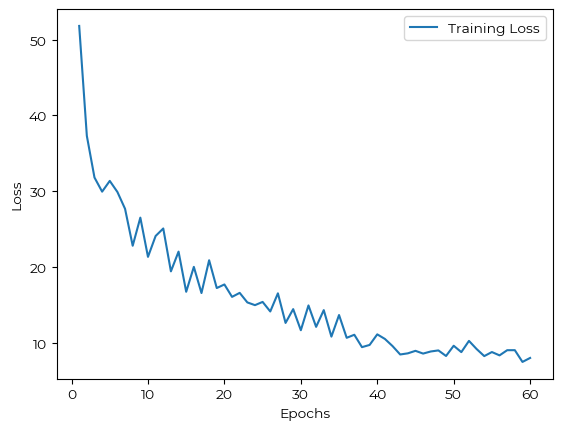

2023-08-24 12:31:07.793898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 277ms/step


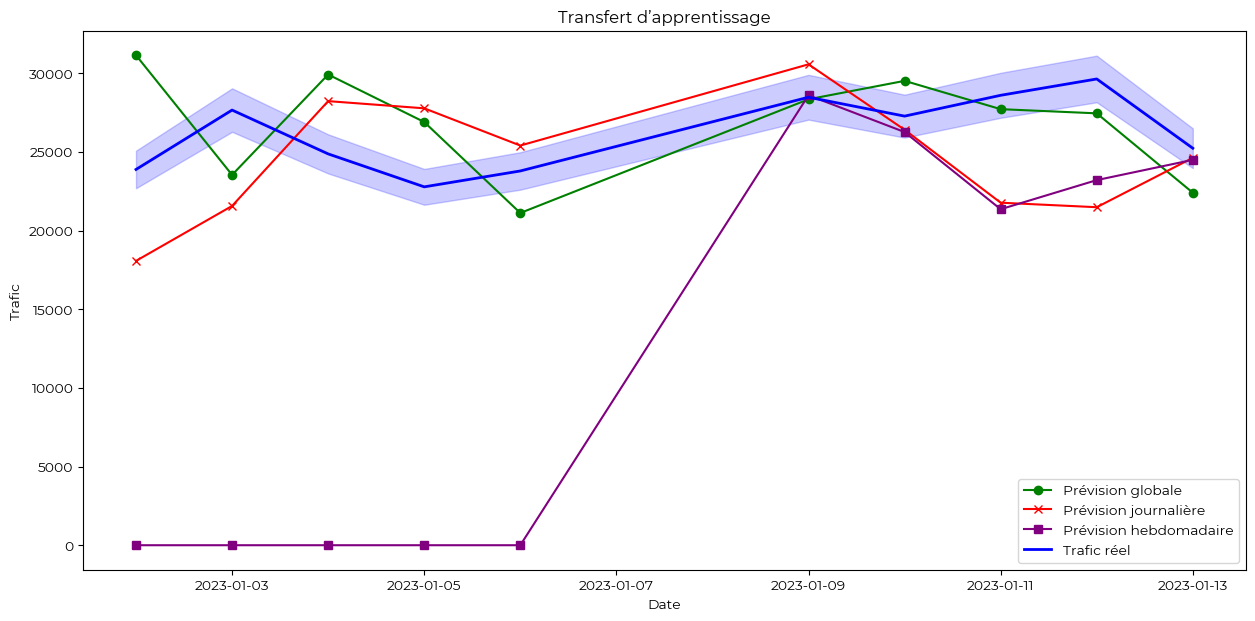

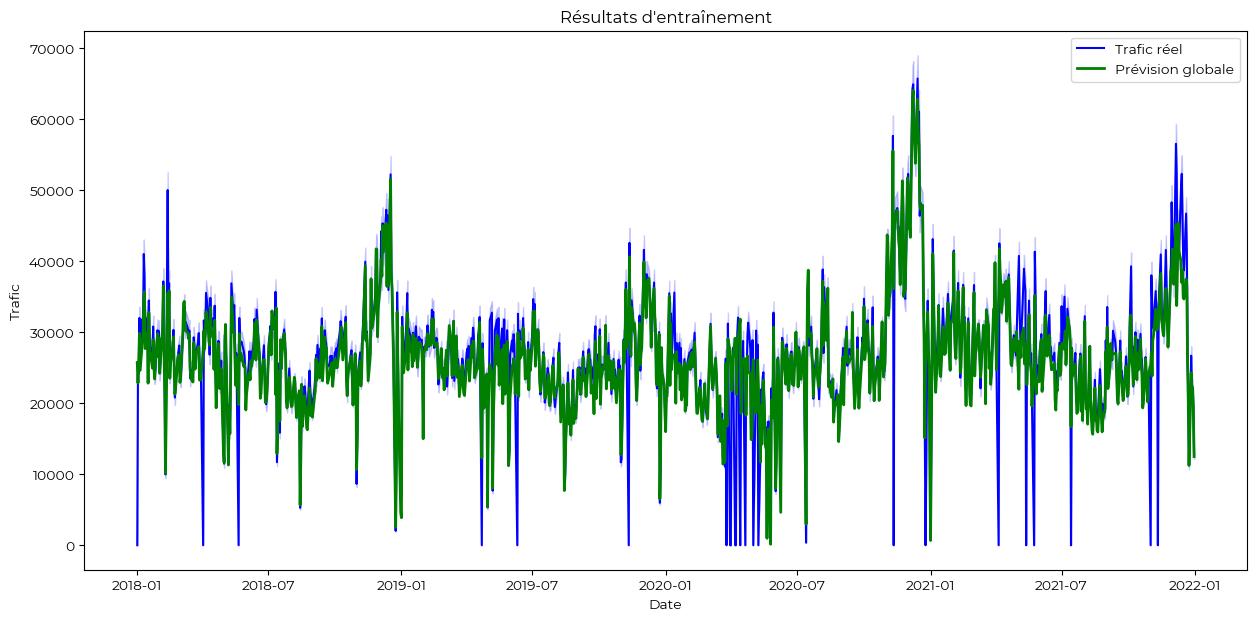

Train MAPE Prévision globale - Average: 5.71% | Max: 720.33%
Test MAPE Prévision globale - Average: 12.52% | Max: 30.40%
Test MAPE Prévision journalière - Average: 15.29% | Max: 27.51%
Test MAPE Prévision hebdomadaire - Average: 55.41% | Max: 100.00%
64 14 l1_l2 0 0.01
Epoch 1/60


2023-08-24 12:32:09.407732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 16s 176ms/step - loss: 41.8043 - custom_mape: 40.9155 - custom_mae: 13.2223
Epoch 2/60
33/33 [==============================] - 2s 72ms/step - loss: 28.8721 - custom_mape: 28.0840 - custom_mae: 9.2453
Epoch 3/60
33/33 [==============================] - 3s 81ms/step - loss: 27.4917 - custom_mape: 26.7182 - custom_mae: 8.3482
Epoch 4/60
33/33 [==============================] - 3s 77ms/step - loss: 28.6641 - custom_mape: 28.0106 - custom_mae: 8.4905
Epoch 5/60
33/33 [==============================] - 3s 87ms/step - loss: 21.0967 - custom_mape: 20.4777 - custom_mae: 7.4504
Epoch 6/60
33/33 [==============================] - 2s 73ms/step - loss: 27.6029 - custom_mape: 26.8774 - custom_mae: 8.0302
Epoch 7/60
33/33 [==============================] - 3s 78ms/step - loss: 22.8438 - custom_mape: 22.2327 - custom_mae: 7.3163
Epoch 8/60
33/33 [==============================] - 2s 70ms/step - loss: 19.2459 - custom_mape: 18.6703 - custom_mae: 6.2858
Epoch 9/

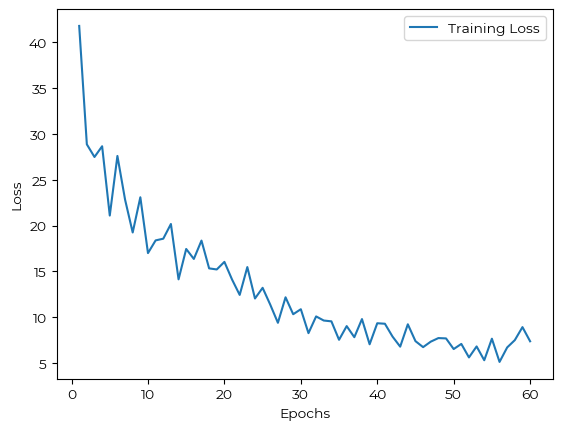

2023-08-24 12:34:57.610009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 284ms/step


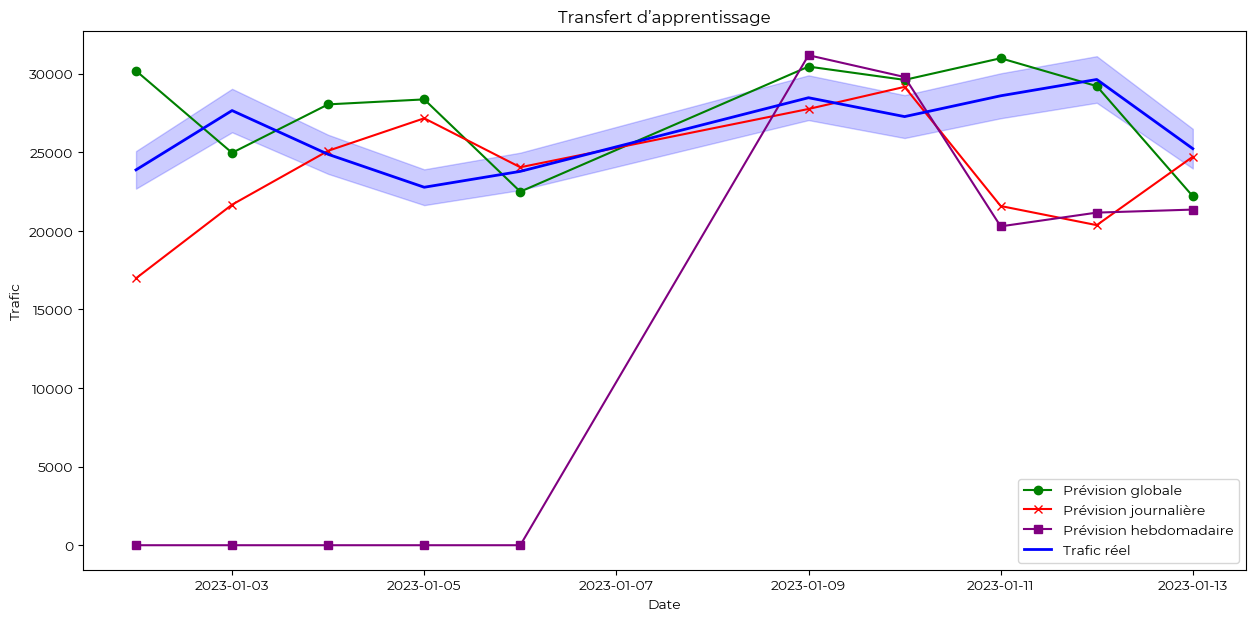

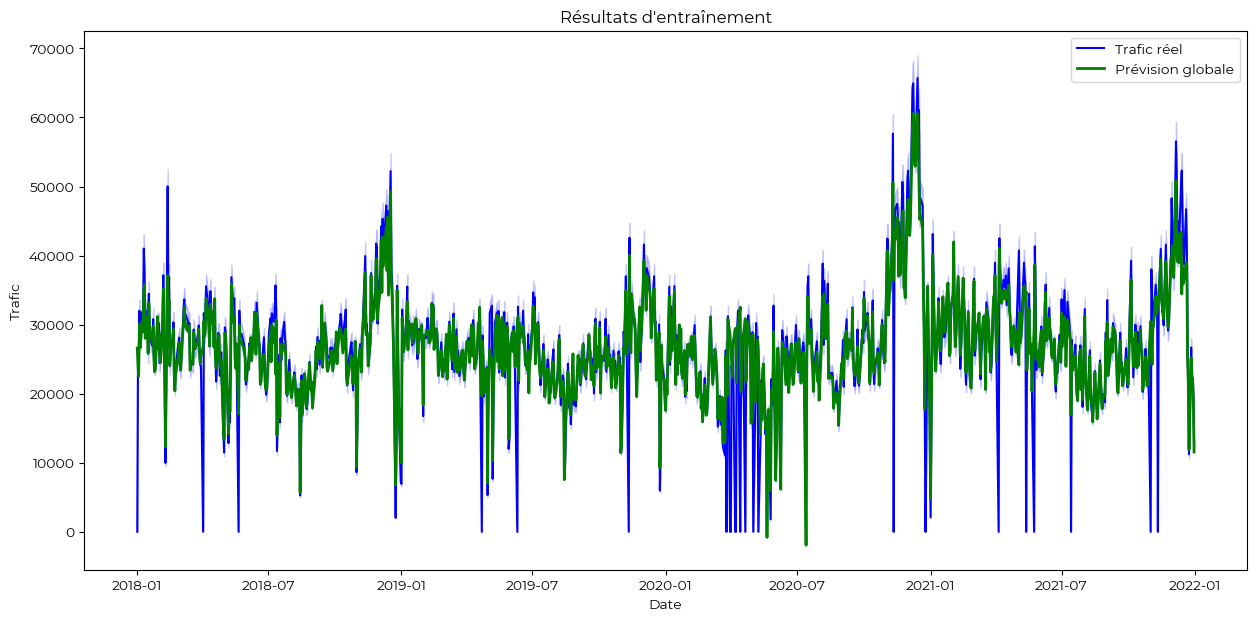

Train MAPE Prévision globale - Average: 5.66% | Max: 640.40%
Test MAPE Prévision globale - Average: 11.62% | Max: 26.40%
Test MAPE Prévision journalière - Average: 13.91% | Max: 31.28%
Test MAPE Prévision hebdomadaire - Average: 59.17% | Max: 100.00%
64 14 l1_l2 0 0.001
Epoch 1/60


2023-08-24 12:35:43.899379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 8s 171ms/step - loss: 49.1333 - custom_mape: 48.8699 - custom_mae: 16.4388
Epoch 2/60
21/33 [==================>...........] - ETA: 0s - loss: 36.0589 - custom_mape: 35.9944 - custom_mae: 10.0073

KeyboardInterrupt: 

In [55]:
# Paramètres du modèle

from datetime import datetime, timedelta

filters = [64, 128]
kernels = [14, 21]
list1 = [0, 1e-1, 1e-2, 1e-3, 1e-4]
list2 = [0, 1e-1, 1e-2, 1e-3, 1e-4]
reg_type = ["l1", "l2", "l1_l2"]



for filt in filters:
    for kernel in kernels:
            for reg in reg_type:
                # Si 'reg' est "l1", alors on n'a besoin que de parcourir les valeurs de "l1".
                # De même pour "l2". Si 'reg' est "l1_l2", alors on parcourt les deux listes.
                l1_values = list1 if reg in ['l1', 'l1_l2'] else [None]
                l2_values = list2 if reg in ['l2', 'l1_l2'] else [None]

                for L1 in l1_values:
                    for L2 in l2_values:
                        print(filt, kernel, reg, L1, L2)
                        model_params_cnn = {
                            "filters": filt,
                            "kernel_size": kernel,
                            "activation": "relu",
                            "n_steps_in": n_steps_in,
                            "n_features": 2,
                            "optimizer": 'adam',
                            "loss": custom_mape,
                            "reg_type" : reg,
                            "l1_value" : L1,
                            "l2_value" : L2
                        }

                        mapes_train, mapes_test = run_cnn(model_params_cnn)

                        results.append({
                            'filters': filt,
                            'kernel': kernel,
                            'reg_type': reg,
                            'l1_value': L1,
                            'l2_value': L2,
                            'mapes_train': mapes_train,
                            'mapes_test': mapes_test
                        })


results_df = pd.DataFrame(results)        
            

In [18]:
import pandas as pd

# Transformez les dictionnaires en colonnes
mapes_train_df = pd.json_normalize(results_df['mapes_train'])
mapes_test_df = pd.json_normalize(results_df['mapes_test'])

# Renommez les colonnes pour une meilleure clarté
mapes_train_df.columns = [col.replace("Prévision globale.", "train_") for col in mapes_train_df.columns]
mapes_test_df.columns = [col.replace("Prévision globale.", "test_") for col in mapes_test_df.columns]

# Supprimez les colonnes originales "mapes_train" et "mapes_test"
results_df.drop(columns=['mapes_train', 'mapes_test'], inplace=True)

# Concaténez les dataframes pour obtenir le résultat final
df = pd.concat([results_df, mapes_train_df, mapes_test_df], axis=1)


print(df)

NameError: name 'results_df' is not defined

# Regularization analysis

In [27]:
df_regul = pd.read_csv('your_file_flat.csv')

df_regul.rename(columns={'mapes_train.Prévision globale.avg_mape': 'train_avg_mape'}, inplace=True)
df_regul.rename(columns={'mapes_train.Prévision globale.max_mape': 'train_max_mape'}, inplace=True)
df_regul.rename(columns={'mapes_test.Prévision globale.avg_mape': 'test_avg_mape'}, inplace=True)
df_regul.rename(columns={'mapes_test.Prévision globale.max_mape': 'test_max_mape'}, inplace=True)
df_regul.rename(columns={'mapes_test.Prévision journalière.avg_mape': 'daily_avg_mape'}, inplace=True)
df_regul.rename(columns={'mapes_test.Prévision journalière.max_mape': 'daily_max_mape'}, inplace=True)
df_regul.rename(columns={'mapes_test.Prévision hebdomadaire.avg_mape': 'weekly_avg_mape'}, inplace=True)
df_regul.rename(columns={'mapes_test.Prévision hebdomadaire.max_mape': 'weekly_max_mape'}, inplace=True)




filters = [16,64]
kernels = [7,14,21]
reguls = ['l1', 'l2', 'l1_l2']

dict = {} #to stock all df
for filter_value in filters:
    for kernel in kernels:
        for regul in reguls:
            key = f'df_{filter_value}_{kernel}_{regul}'
            dict[key] = df_regul[(df_regul['reg_type'] == regul) & (df_regul['filters'] == filter_value) & (df_regul['kernel'] == kernel)]

        
print(dict)




{'df_16_7_l1':    filters  kernel reg_type  l1_value  l2_value  train_avg_mape  \
0       16       7       l1    0.0000       NaN        5.136994   
1       16       7       l1    0.1000       NaN        9.692724   
2       16       7       l1    0.0100       NaN        6.954629   
3       16       7       l1    0.0010       NaN       10.511226   
4       16       7       l1    0.0001       NaN        5.970723   

   train_max_mape  test_avg_mape  test_max_mape  daily_avg_mape  \
0      416.497226      11.353052      28.554495        8.194312   
1     1337.724202       9.955683      20.844556       11.853798   
2      414.727842       9.635187      21.761703        9.820297   
3     1418.662109      14.820583      39.811995       12.919461   
4      168.652271      12.857595      27.400932       13.164828   

   daily_max_mape  weekly_avg_mape  weekly_max_mape  
0       23.303005        53.690808            100.0  
1       27.035998        55.760284            100.0  
2       18.932698

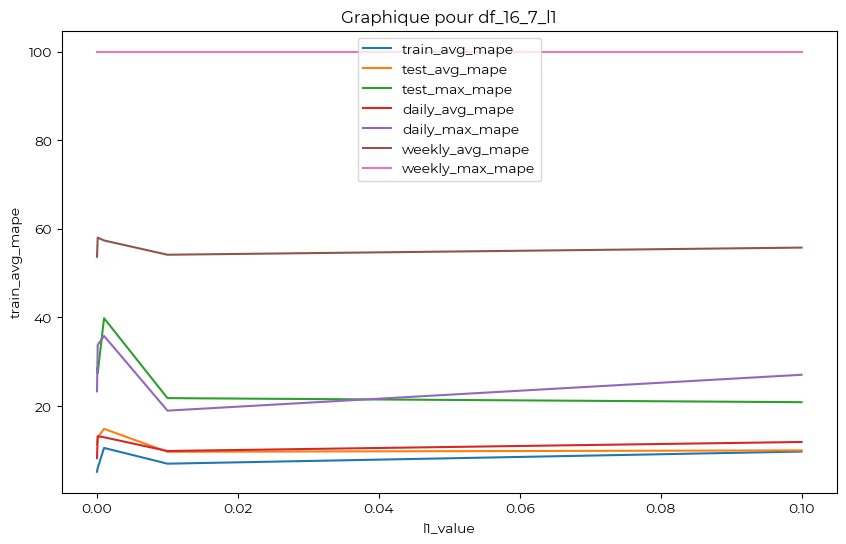

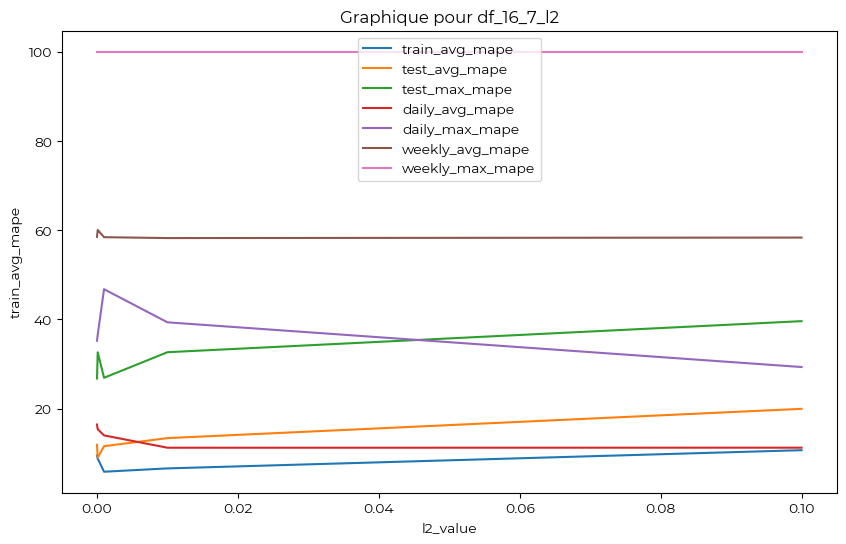

<Figure size 1000x600 with 0 Axes>

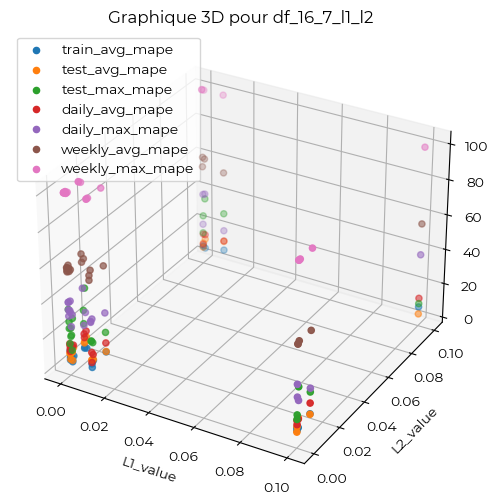

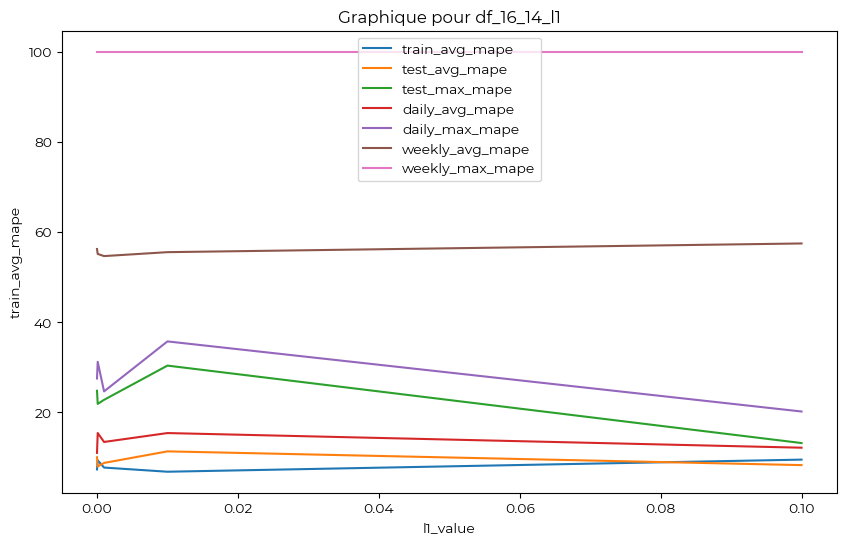

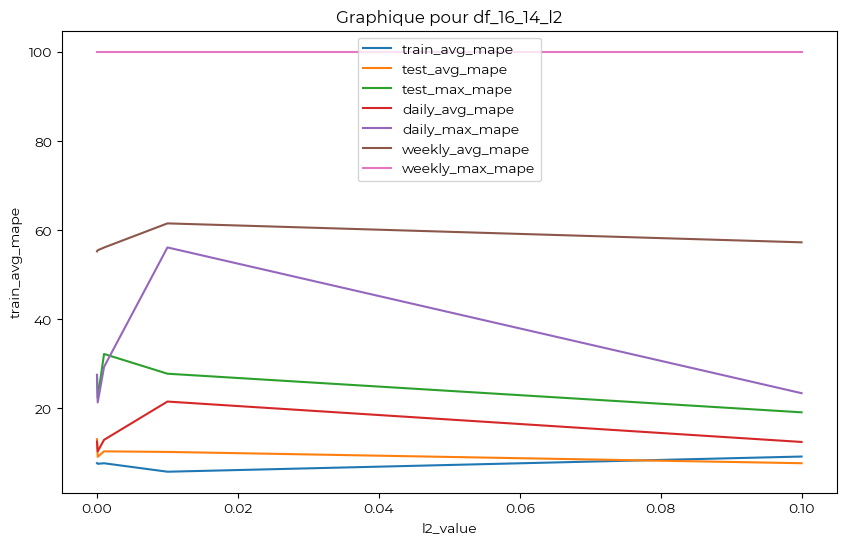

<Figure size 1000x600 with 0 Axes>

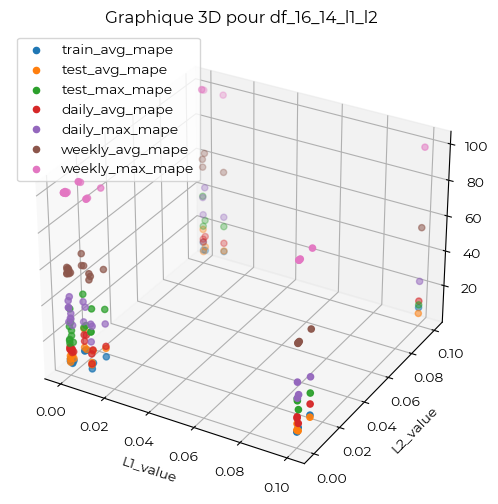

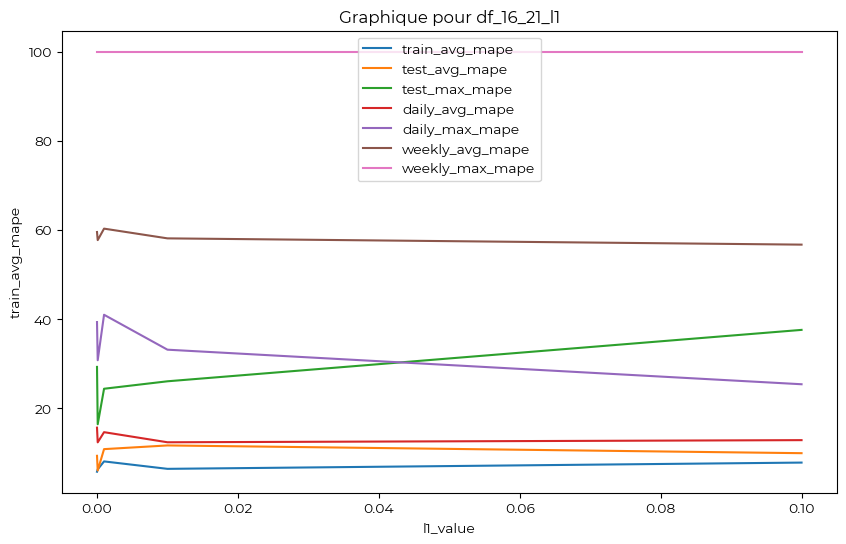

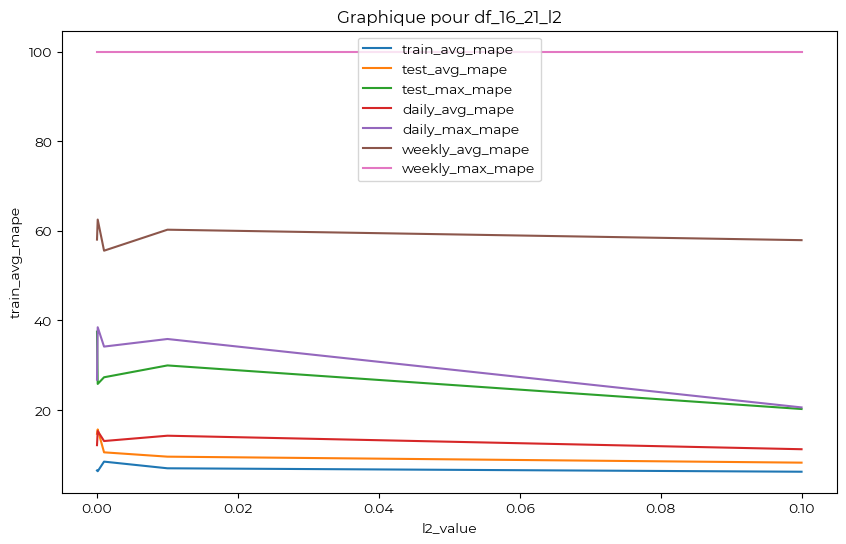

<Figure size 1000x600 with 0 Axes>

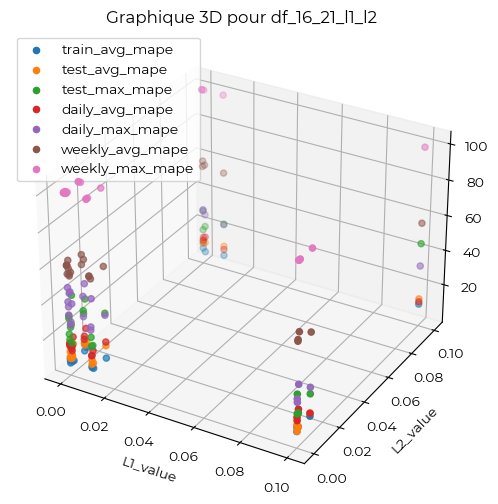

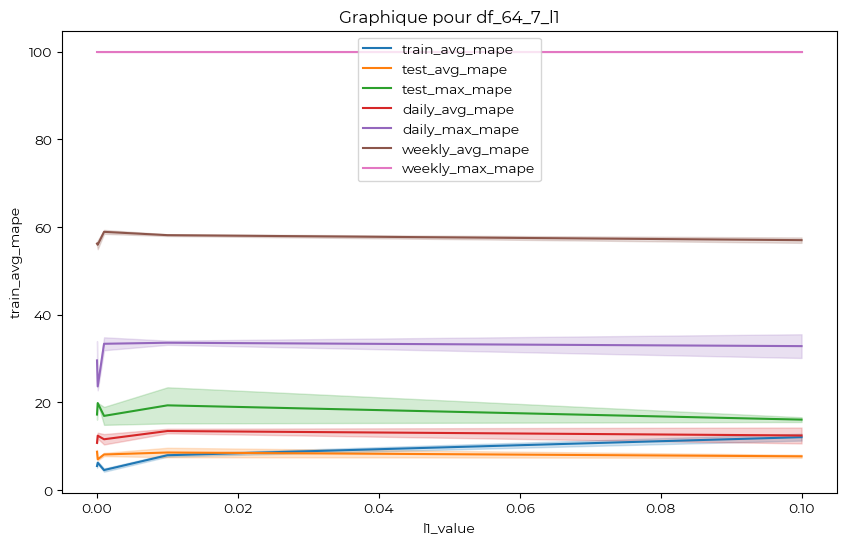

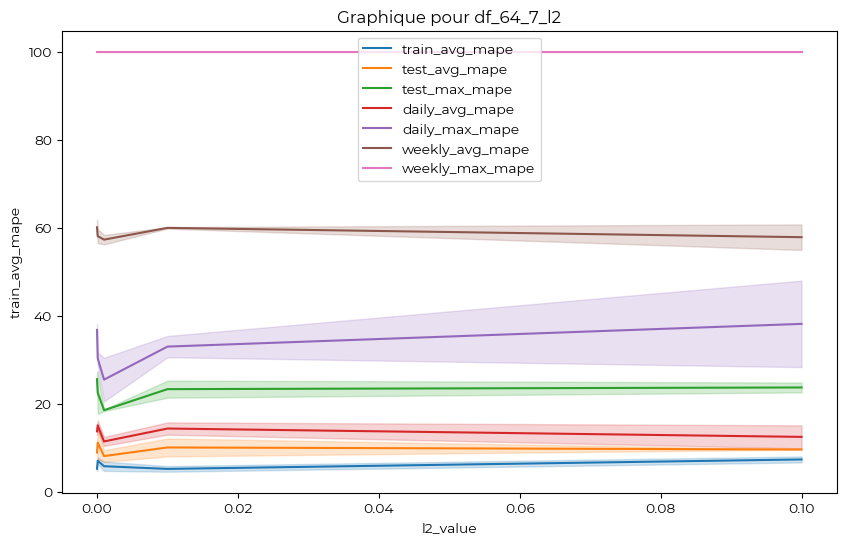

<Figure size 1000x600 with 0 Axes>

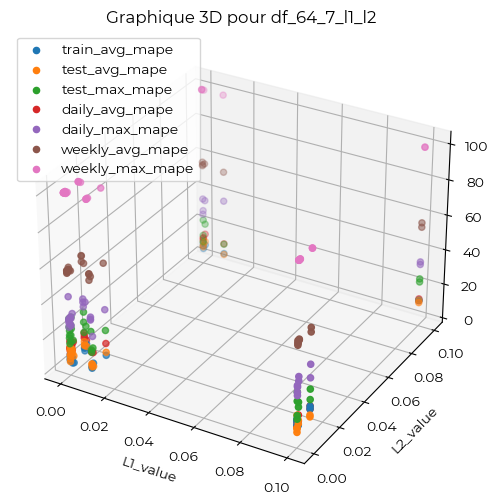

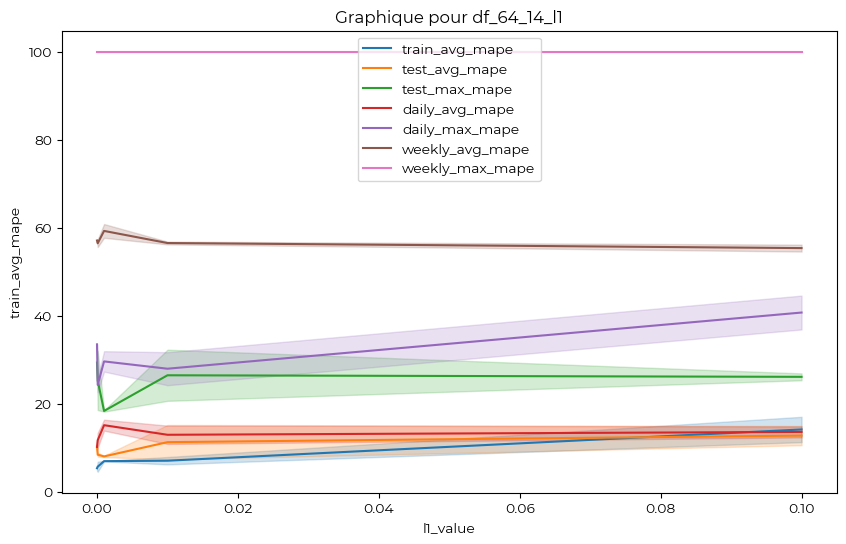

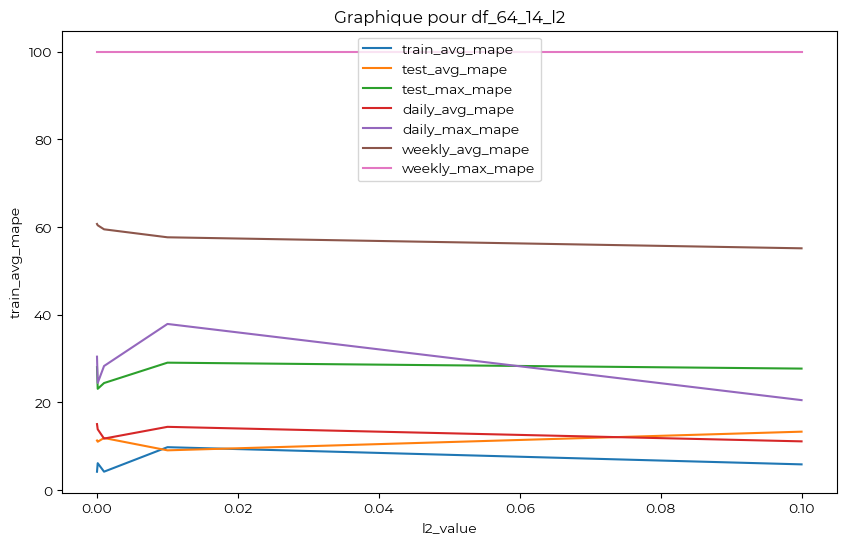

<Figure size 1000x600 with 0 Axes>

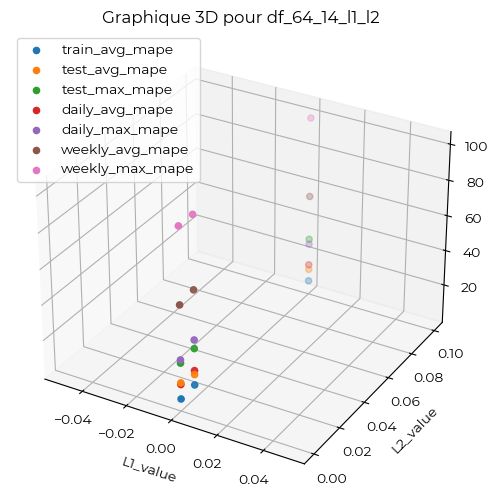

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


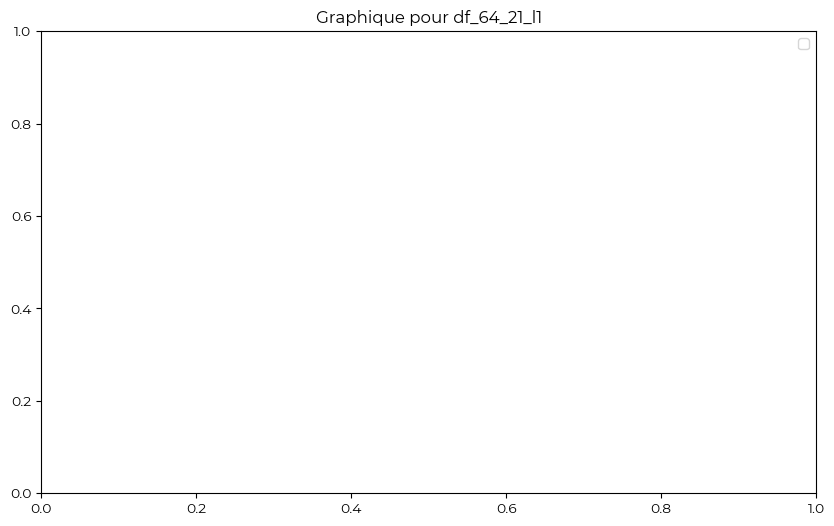

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


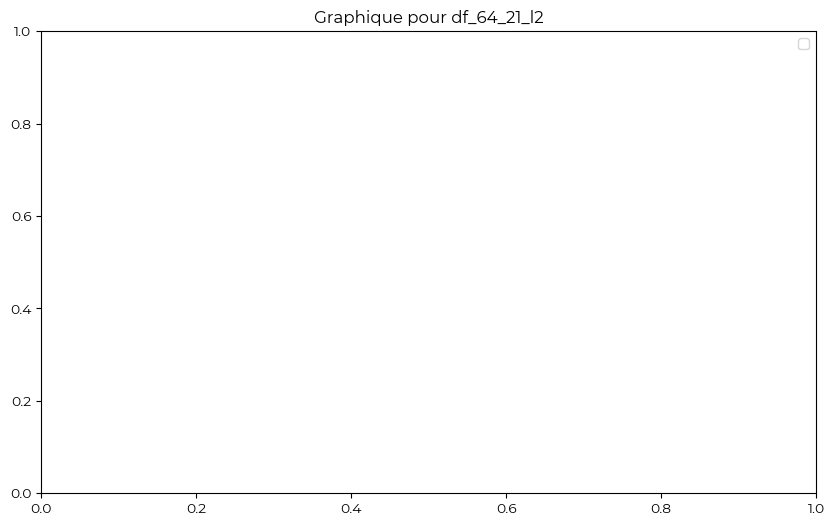

<Figure size 1000x600 with 0 Axes>

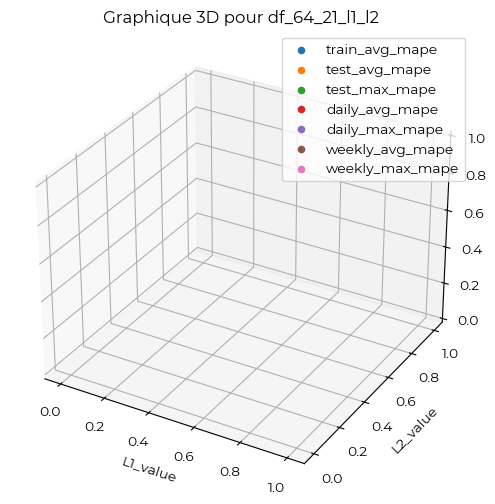

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des colonnes à afficher en y
y_columns = ['train_avg_mape', 'test_avg_mape', 'test_max_mape', 
             'daily_avg_mape', 'daily_max_mape', 'weekly_avg_mape', 'weekly_max_mape']

# Parcourir le dictionnaire
for key, sub_df in dict.items():
    plt.figure(figsize=(10, 6))
    
    # Si la clé finit par l1
    if key.endswith('l1'):
        for col in y_columns:
            sns.lineplot(data=sub_df, x='l1_value', y=col, label=col)
        plt.title(f'Graphique pour {key}')
        plt.legend()
        plt.show()
    
    # Si la clé finit par l2
    elif key.endswith('l1_l2'):
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        for col in y_columns:
            ax.scatter(sub_df['l1_value'], sub_df['l2_value'], sub_df[col], label=col)
        ax.set_xlabel('L1_value')
        ax.set_ylabel('L2_value')
        ax.set_title(f'Graphique 3D pour {key}')
        ax.legend()
        plt.show()

    
    # Si la clé finit par l1_l2
    elif key.endswith('l2'):
        for col in y_columns:
            sns.lineplot(data=sub_df, x='l2_value', y=col, label=col)
        plt.title(f'Graphique pour {key}')
        plt.legend()
        plt.show()
